In [1]:
# import packages 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import os
from astropy import units as u
from astropy import constants as const
from astropy.io import fits
from astropy.time import Time
import pandas as pd
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, NullFormatter
from matplotlib import ticker
import pandas as pd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.stats import binned_statistic, norm
import pylag
import emcee

from timing import *

# set up plotting defaults
plt.rc('font', family='sans')
params = {
   'axes.labelsize': 40,
   'axes.linewidth': 3,
   'legend.fontsize': 30,
   'legend.frameon': True,
   'legend.fancybox': False,
   'legend.framealpha': 0.8,
   'legend.edgecolor': 'k',
   'lines.linewidth': 2,
   'font.size': 40,
   'font.weight': 'normal',
   'xtick.direction': 'in',
   'xtick.labelsize': 35,
   'xtick.color':'k',
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 18,
   'xtick.major.width': 2,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 10,
   'xtick.minor.size': 9,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 2,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 35,
   'ytick.left': True,
   'ytick.right': True,
   'ytick.major.pad': 10,
   'ytick.major.size': 18,
   'ytick.major.width': 2,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 9,
   'ytick.minor.visible': True,
   'ytick.minor.width': 2,
   'text.usetex': False,
   'figure.figsize': [10,10],
   'savefig.dpi': 500,
   }
plt.rcParams.update(params)

fig_path = '../figures/'
data_path = '../data/lightcurves/'
mcmc_path_qpo = '../code/qpo_mcmcs/'

# info for the observations
obs = ['0671860201', '0830191101', '0831790301', '0843270101', '0843270201', '0863230101', '0863230201', '0863230301', '0902590201', '0915390701', '0931791401', '0932392001']
print_times = ['2011-05-20', '2018-06-05', '2018-12-12', '2019-05-06', '2019-11-02', '2020-05-03', '2020-09-16', '2021-01-12', '2022-07-26/28', '2023-02-21', '2023-08-07', '2024-03-04']
print_times = ['May 2011', 'June 2018', 'Dec. 2018', 'May 2019', 'Nov. 2019', 'May 2020', 'Sept. 2020', 'Jan. 2021', 'July/Aug. 2022', 'Feb. 2023', 'Aug. 2023', 'Mar. 2024']
for_mjd_times = ['2011-05-20', '2018-06-05', '2018-12-12', '2019-05-06', '2019-11-02', '2020-05-03', '2020-09-16', '2021-01-12', '2022-07-27', '2023-02-21', '2023-08-07', '2024-03-04']

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(0.019422) 
print('Distance to 1ES 1927+654 = {:.2f}'.format(d_L))

save = False

/Users/megan/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Distance to 1ES 1927+654 = 84.42 Mpc


### Read in the NICER data + XMM fluxes

In [20]:
# load in the NICER data
tot = pd.read_pickle('../data/nicer/lc_data_0.3-10.0keV_GTIbased.pkl') # total
soft = pd.read_pickle('../data/nicer/lc_data_0.3-2.0keV_GTIbased.pkl') # soft
hard = pd.read_pickle('../data/nicer/lc_data_2.0-10.0keV_GTIbased.pkl') # hard

tot_rate = tot['net_rate']
tot_err = tot['net_rate_err']

hrat = hard['net_rate'] / soft['net_rate']
hrat_err = hrat * np.sqrt((hard['net_rate_err'] / hard['net_rate'])**2 + \
                          (soft['net_rate_err'] / soft['net_rate'])**2)

# use only these gtis AND ONLY THE DATA FROM MJD 59100
good = (tot['good_GTI'] & soft['good_GTI'] & hard['good_GTI'])

# grab the times
nicer_time = tot['mjd'][good]

#  load in the XMM data
data = np.loadtxt('../../../1ES1927/data/paper_figs/1ES_XMM+NuSTAR_forKeri.txt', skiprows=1)
xmm_lumin = data[:,2]
xmm_flux = xmm_lumin / (4 * np.pi * d_L.to(u.cm).value**2)
xmm_flux = np.append(xmm_flux, [1.77e-11, 3.94e-11, 4.99e-11, 5.46e-11]) # add more recent observations

### Set up colors for figures

In [21]:
# color map based on the NICER times
cmap = plt.cm.plasma_r  # Choose a colormap
norm = Normalize(vmin=nicer_time.min()-150, vmax=nicer_time.max()+250)
colors = cmap(norm(nicer_time))
xmm_time = np.array([Time('2018-06-05').decimalyear, Time('2018-12-12').decimalyear, Time('2019-05-06').decimalyear,
                       Time('2019-11-02').decimalyear, Time('2020-05-03').decimalyear, Time('2020-09-16').decimalyear,
                       Time('2021-01-12').decimalyear, Time('2022-08-01').decimalyear, Time('2023-02-21').decimalyear, 
                       Time('2023-08-07').decimalyear, Time('2024-03-04').decimalyear])
xmm_colors = cmap(norm(Time(xmm_time, format='decimalyear').mjd))
save_color = np.concatenate([np.array([(0.5, 0.5, 0.5, 1)]), xmm_colors])

### QPO + spectral fit information

In [4]:
qpo_obs = np.array(['0902590201', '0915390701', '0931791401', '0932392001'])
qpo_times = np.array([Time('2022-08-01').decimalyear, Time('2023-02-21').decimalyear, Time('2023-08-07').decimalyear, Time('2024-03-04').decimalyear])
qpo_print_times = np.array(['July/Aug. 2022', 'Feb. 2023', 'Aug. 2023', 'Mar. 2024'])
qpo_freq = np.array([0.91,1.67,2.21,2.35]) # mHz
qpo_freq_err = np.array([0.06, 0.02, 0.03, 0.05])

# THESE ARE 68% ERRORS ON SPECTRAL PARAMETERS
gamma = np.array([2.63, 3.11, 3.21, 3.19])
gamma_loerr = np.array([0.03, 0.03, 0.03, 0.04])
gamma_uperr = np.array([0.03, 0.03, 0.03, 0.04])
flux_2to10 = np.array([4.64, 5.92, 6.45, 6.56]) * 1e-12
flux_2to10_lo = np.array([4.59, 5.82, 6.35, 6.44]) * 1e-12
flux_2to10_up = np.array([4.71, 6.02, 6.52, 6.70]) * 1e-12
flux_0p3to10 = np.array([1.73, 3.85, 4.96, 5.47]) * 1e-11
flux_0p3to10_lo = np.array([1.72, 3.84, 4.95, 5.45]) * 1e-11
flux_0p3to10_up = np.array([1.74, 3.86, 4.98, 5.49]) * 1e-11
flux_0p3to2 = flux_0p3to10 - flux_2to10
flux_2to10_err = np.array([flux_2to10-flux_2to10_lo, flux_2to10_up-flux_2to10])
flux_0p3to10_err = np.array([flux_0p3to10-flux_0p3to10_lo, flux_0p3to10_up-flux_0p3to10])
flux_0p3to2_err = np.sqrt(flux_2to10_err**2 + flux_0p3to10_err**2)

### Fig. 1

/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_80900/3185455317.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(Time(nicer_time, format='mjd').decimalyear, tot_rate[good] * ct_to_flux, c=colors, cmap=cmap, edgecolor='k', s=300, lw=1, label='NICER', zorder=10)


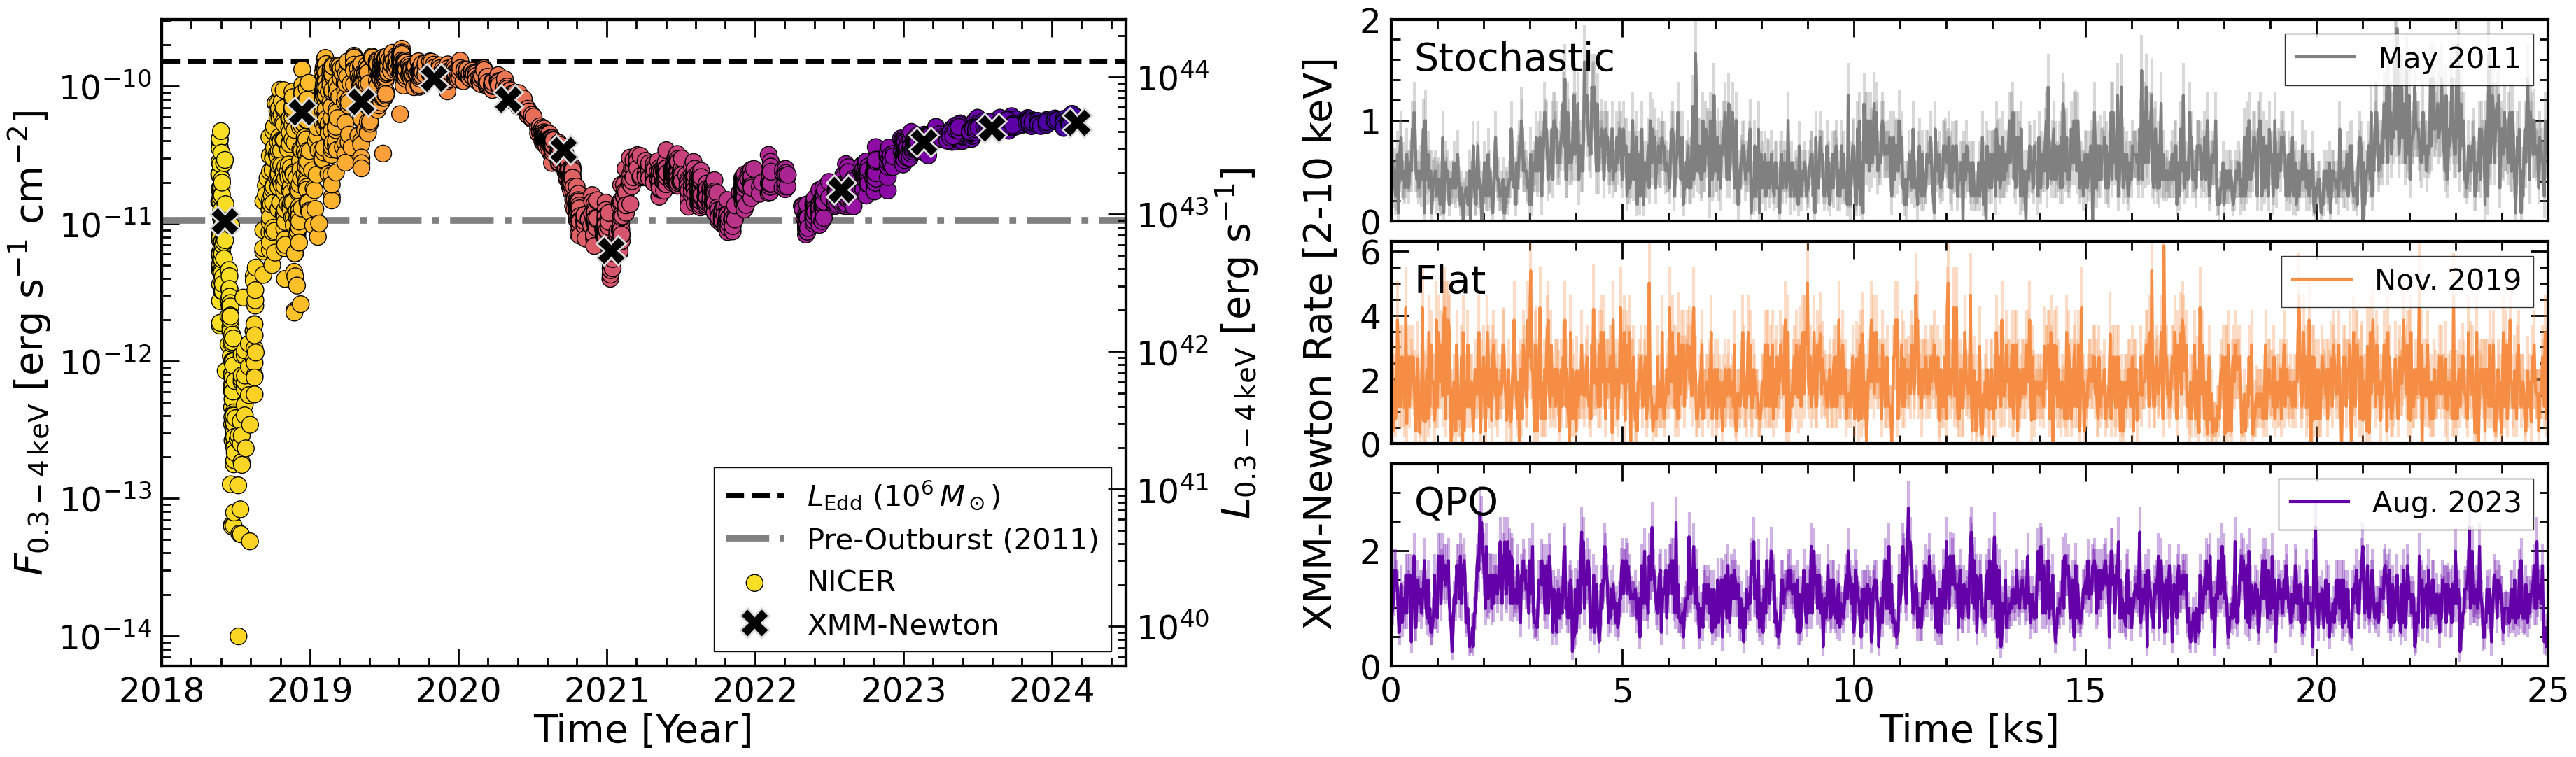

In [5]:
mosaic = """
    AB
    AC
    AD
    """

fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(44,12), width_ratios=[1,1.2], gridspec_kw={'hspace':0.1, 'wspace':0.25})

# first panel
ax = axs['A']
ct_to_flux = 1.088e-12 # gamma = 3, nH = 6e20, 0.3-10 keV
time = tot['mjd']
ax.axhline(((1.3e44 * u.erg / u.s) / (4 * np.pi * d_L.to(u.cm).value**2)).value, color='k', ls='--', lw=5, label=r'$L_\mathrm{Edd}$ ($10^6 \, M_\odot$)')
ax.axhline((6.8+3.7) * 1e-12, color='grey', ls='-.', lw=7, label='Pre-Outburst (2011)') # THIS IS 0.3-10 KEV
ax.set_ylabel(r'$F_\mathrm{0.3-4 \, keV}$ [erg s$^{-1}$ cm$^{-2}$]')
ax.set_xlabel('Time [Year]')
ax.set_xlim(2018.0,2024.5)
# nicer data
sc = ax.scatter(Time(nicer_time, format='mjd').decimalyear, tot_rate[good] * ct_to_flux, c=colors, cmap=cmap, edgecolor='k', s=300, lw=1, label='NICER', zorder=10)
# xmm data
ax.plot(xmm_time, xmm_flux, 'X', color='k', ms=30, mew=2, mec='gainsboro', label='XMM-Newton', zorder=10)
ax.legend(loc='lower right', framealpha=0.95)

# add luminosity axis
ax.set_yscale('log')
axr = ax.twinx()
axr.set_ylim(ax.get_ylim()[0] * 4 * np.pi * d_L.to(u.cm).value**2, ax.get_ylim()[-1] * 4 * np.pi * d_L.to(u.cm).value**2)
axr.set_yscale('log')
axr.set_ylabel(r'$L_\mathrm{0.3-4 \, keV}$ [erg s$^{-1}$]')

labs = ['B', 'C', 'D']
emin = 2.
emax = 10.
tbin = 20
use_inds = np.array([0,4,10])
lc_text = np.array(['Stochastic', 'Flat', 'QPO'])
for i,alp in enumerate(labs):
    ax = axs[alp]

    # load in the data
    lc_file = "PN_"+obs[use_inds[i]]+"_"+str(emin)+"-"+str(emax)+"_"+str(tbin)+"s.lc"
    hdu = fits.open(data_path+lc_file)
    data = hdu[1].data
    data = data[~np.isnan(data['RATE'])]
    time = data['TIME']-data['TIME'][0]
    rate = data['RATE']
    err = data['ERROR']

    if i == 0:
        color = 'grey'
    else:
        color = cmap(norm(Time(for_mjd_times[use_inds[i]]).mjd))
    ax.errorbar(time / 1e3, rate, yerr=err, fmt='-', ms=10, color=color, mew=1.5, mec='k', capsize=0, lw=3, alpha=0.3)
    ax.plot(time / 1e3, rate, '-', color=color, lw=3, label=print_times[use_inds[i]]) 
    # ax.errorbar(time / 1e3, rate, err, fmt='o', color=color, ms=10, capsize=0, mew=1.5, lw=3, mec='k', label=print_times[use_inds[i]])
    ax.set_xlim(0,25)
    if i == 2:
        ax.set_xlabel('Time [ks]')
    else:
        ax.set_xticklabels([])
    if i == 1:
        ax.set_ylabel('XMM-Newton Rate [2-10 keV]', labelpad=20)
    ax.legend(loc='upper right', fontsize=30)
    ax.text(0.02,0.75, lc_text[i], transform=ax.transAxes)
    if i == 2:
        ax.set_ylim(0,3.5)
    if i == 1:
        ax.set_ylim(0,6.3)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    if i == 0:
        ax.set_ylim(0,2)

fig.align_ylabels()
if save: 
    plt.savefig(fig_path+'1ES_NICER_XMMsubset.pdf', bbox_inches='tight')

### Figure 2

[    0. 15300. 32420. 49560.]
YOU HAVE A SERIOUS PROBLEM. YOUR DATA IS NOT CONTINUOUS. YOU ARE LINEARLY INTERPOLATING THE GAPS. MAKE SURE THAT THESE ARE NOT TOO LONG.
[    0. 14700.]


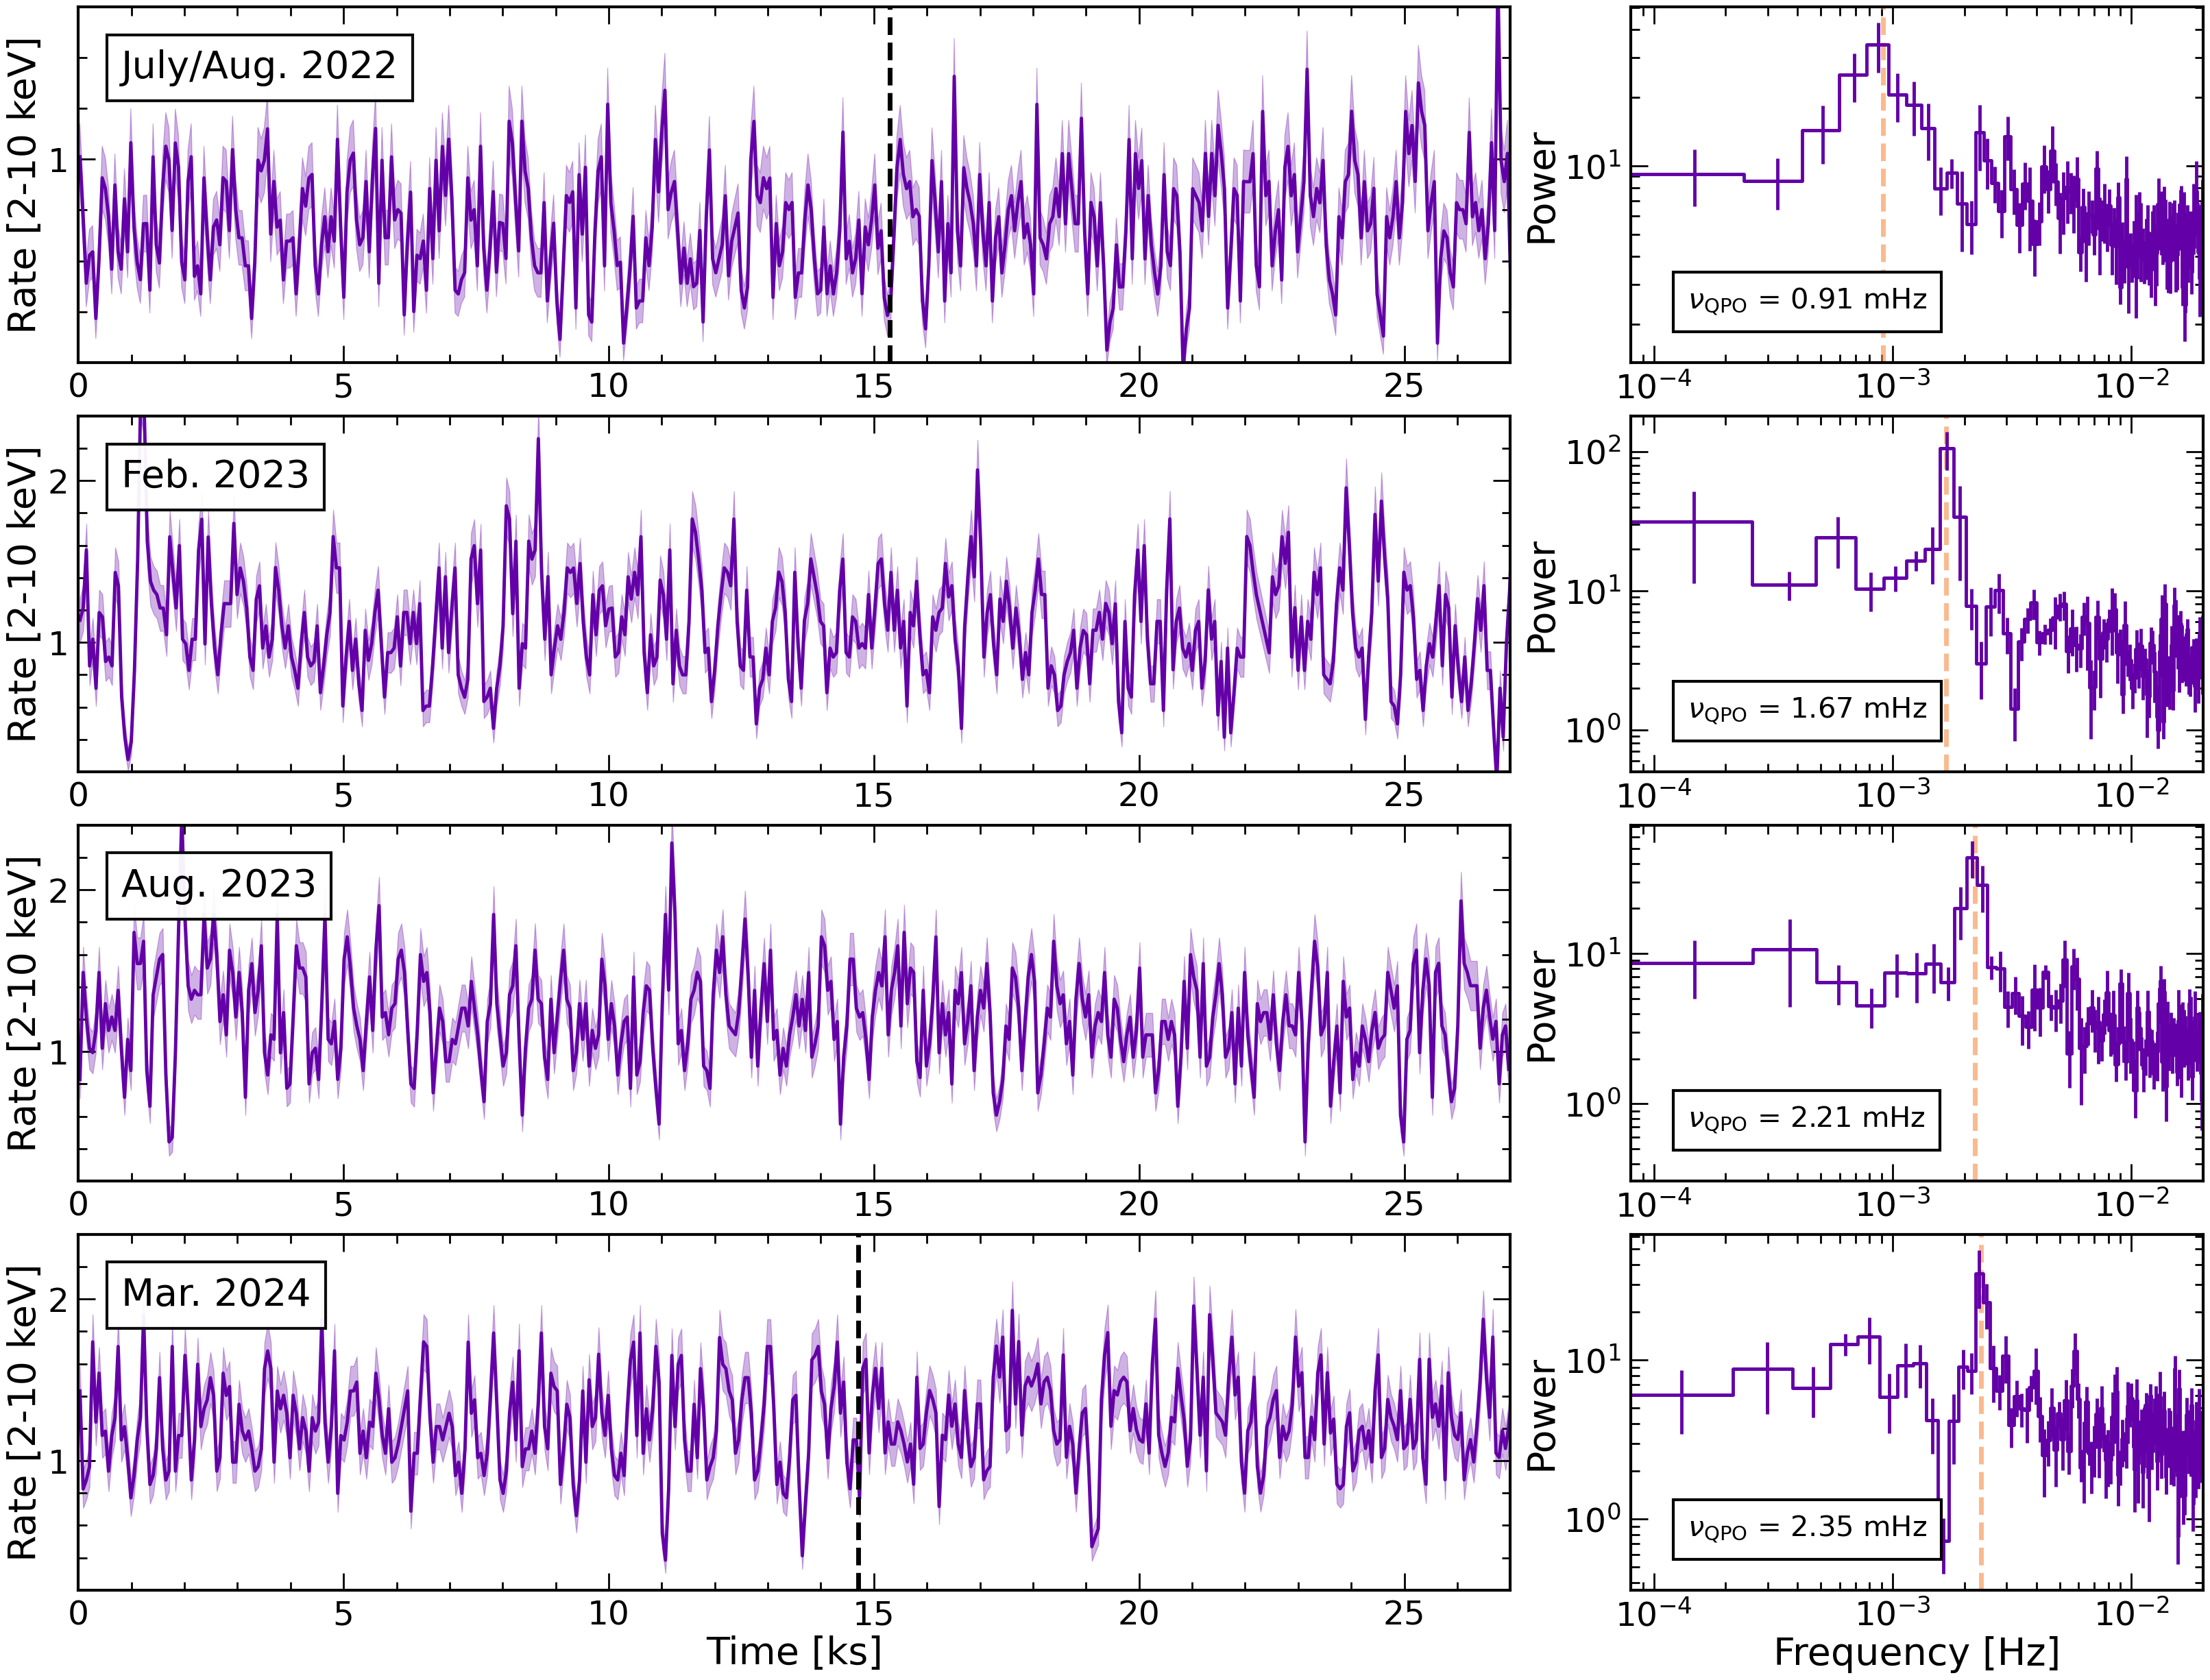

In [6]:
fig, axs = plt.subplots(figsize=(40,30), ncols=2, nrows=4, gridspec_kw={'width_ratios':[1,0.4], 'hspace':0.15, 'wspace':0.12})

color = save_color[-2] 
n = 6
tbin = 20
binned_n = 3
j = 0

ymax = np.array([1.6,2.4,2.4,2.4])

for i,obsid in enumerate(obs):

    if i < 8: 
        continue

    emin = 2.
    emax = 10.
    if obsid == '0902590201': 
        time, rate, err, freq, power, freq_err, power_err, f_min, f_max, tstarts, true_time = make_psd(['0902590201', '0902590301', '0902590401', '0902590501'], 
                                                                                                        data_path, emin, emax, tbin, 2*n)
    elif obsid == '0932392001':    
        time, rate, err, freq, power, freq_err, power_err, f_min, f_max, tstarts, true_time = make_psd(['0932392001','0932392101'], data_path, emin, emax, tbin, n)
    else:    
        time, rate, err, freq, power, freq_err, power_err, f_min, f_max, _, _ = make_psd(obsid, data_path, emin, emax, tbin, n)

    # if you want to bin
    if binned_n is not None:
        rate, edges, bins = binned_statistic(time, rate, statistic='mean', bins=len(time)//binned_n)
        time = (edges[:-1] + edges[1:]) / 2
        err = np.sqrt(tbin * binned_n * rate) / (tbin * binned_n)
        remove_nans = ~np.isnan(rate)
        time = time[remove_nans]
        rate = rate[remove_nans]
        err = err[remove_nans]

    # light curve
    ax = axs[j,0]
    if j == 3:
        ax.set_xlabel('Time [ks]', fontsize=40)
    # ax.errorbar(time / 1e3, rate, yerr=err, fmt='-', ms=10, color=color, mew=1.5, mec='k', capsize=0, lw=3.5, label=print_times[i], alpha=0.3)
    ax.plot(time / 1e3, rate, '-', color=color, lw=3.5, label=print_times[i]) 
    ax.fill_between(time / 1e3, rate - err, rate + err, color=color, alpha=0.3)
    ax.set_ylabel(r'Rate [2-10 keV]', fontsize=40)
    ax.set_xlim(0,27)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_ylim(0.2,ymax[j])

    ax.text(0.03, 0.8, print_times[i], transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.95, edgecolor='k', lw=3, pad=15), fontsize=40)#+', ObsID: '+obsid, fontsize=60, pad=20)
    if obsid == '0902590201' or obsid == '0932392001':
        print(tstarts)
        ax.axvline(tstarts[1] / 1e3, ls='--', lw=5, color='k')  

    # psd
    ax = axs[j,1]
    ax.axvline(qpo_freq[j] / 1e3, lw=5, ls='--', color=save_color[4], alpha=0.6)
    ax.errorbar(freq, power, xerr=freq_err, yerr=power_err, fmt='o', ms=0, color=color, capsize=0, lw=3.5, label=print_times[i]+', 2-10 keV')
    ax.step(freq, power, color=color, lw=3.5, where='mid')
    ax.text(0.1, 0.15, r'$\nu_\mathrm{QPO}$ = '+str(np.round(qpo_freq[j],2))+' mHz', transform=ax.transAxes, 
            bbox=dict(facecolor='w', alpha=1, edgecolor='k', lw=3, pad=15), fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if j == 3:
        ax.set_xlabel('Frequency [Hz]', fontsize=40)
    ax.set_ylabel(r'Power', fontsize=40)
    ax.set_xlim(8e-5, 2e-2)

    j = j + 1

fig.align_ylabels()

if save: 
    plt.savefig(fig_path+'1ES_lc-psd_2-10keV.pdf', bbox_inches='tight')

### Figure 3

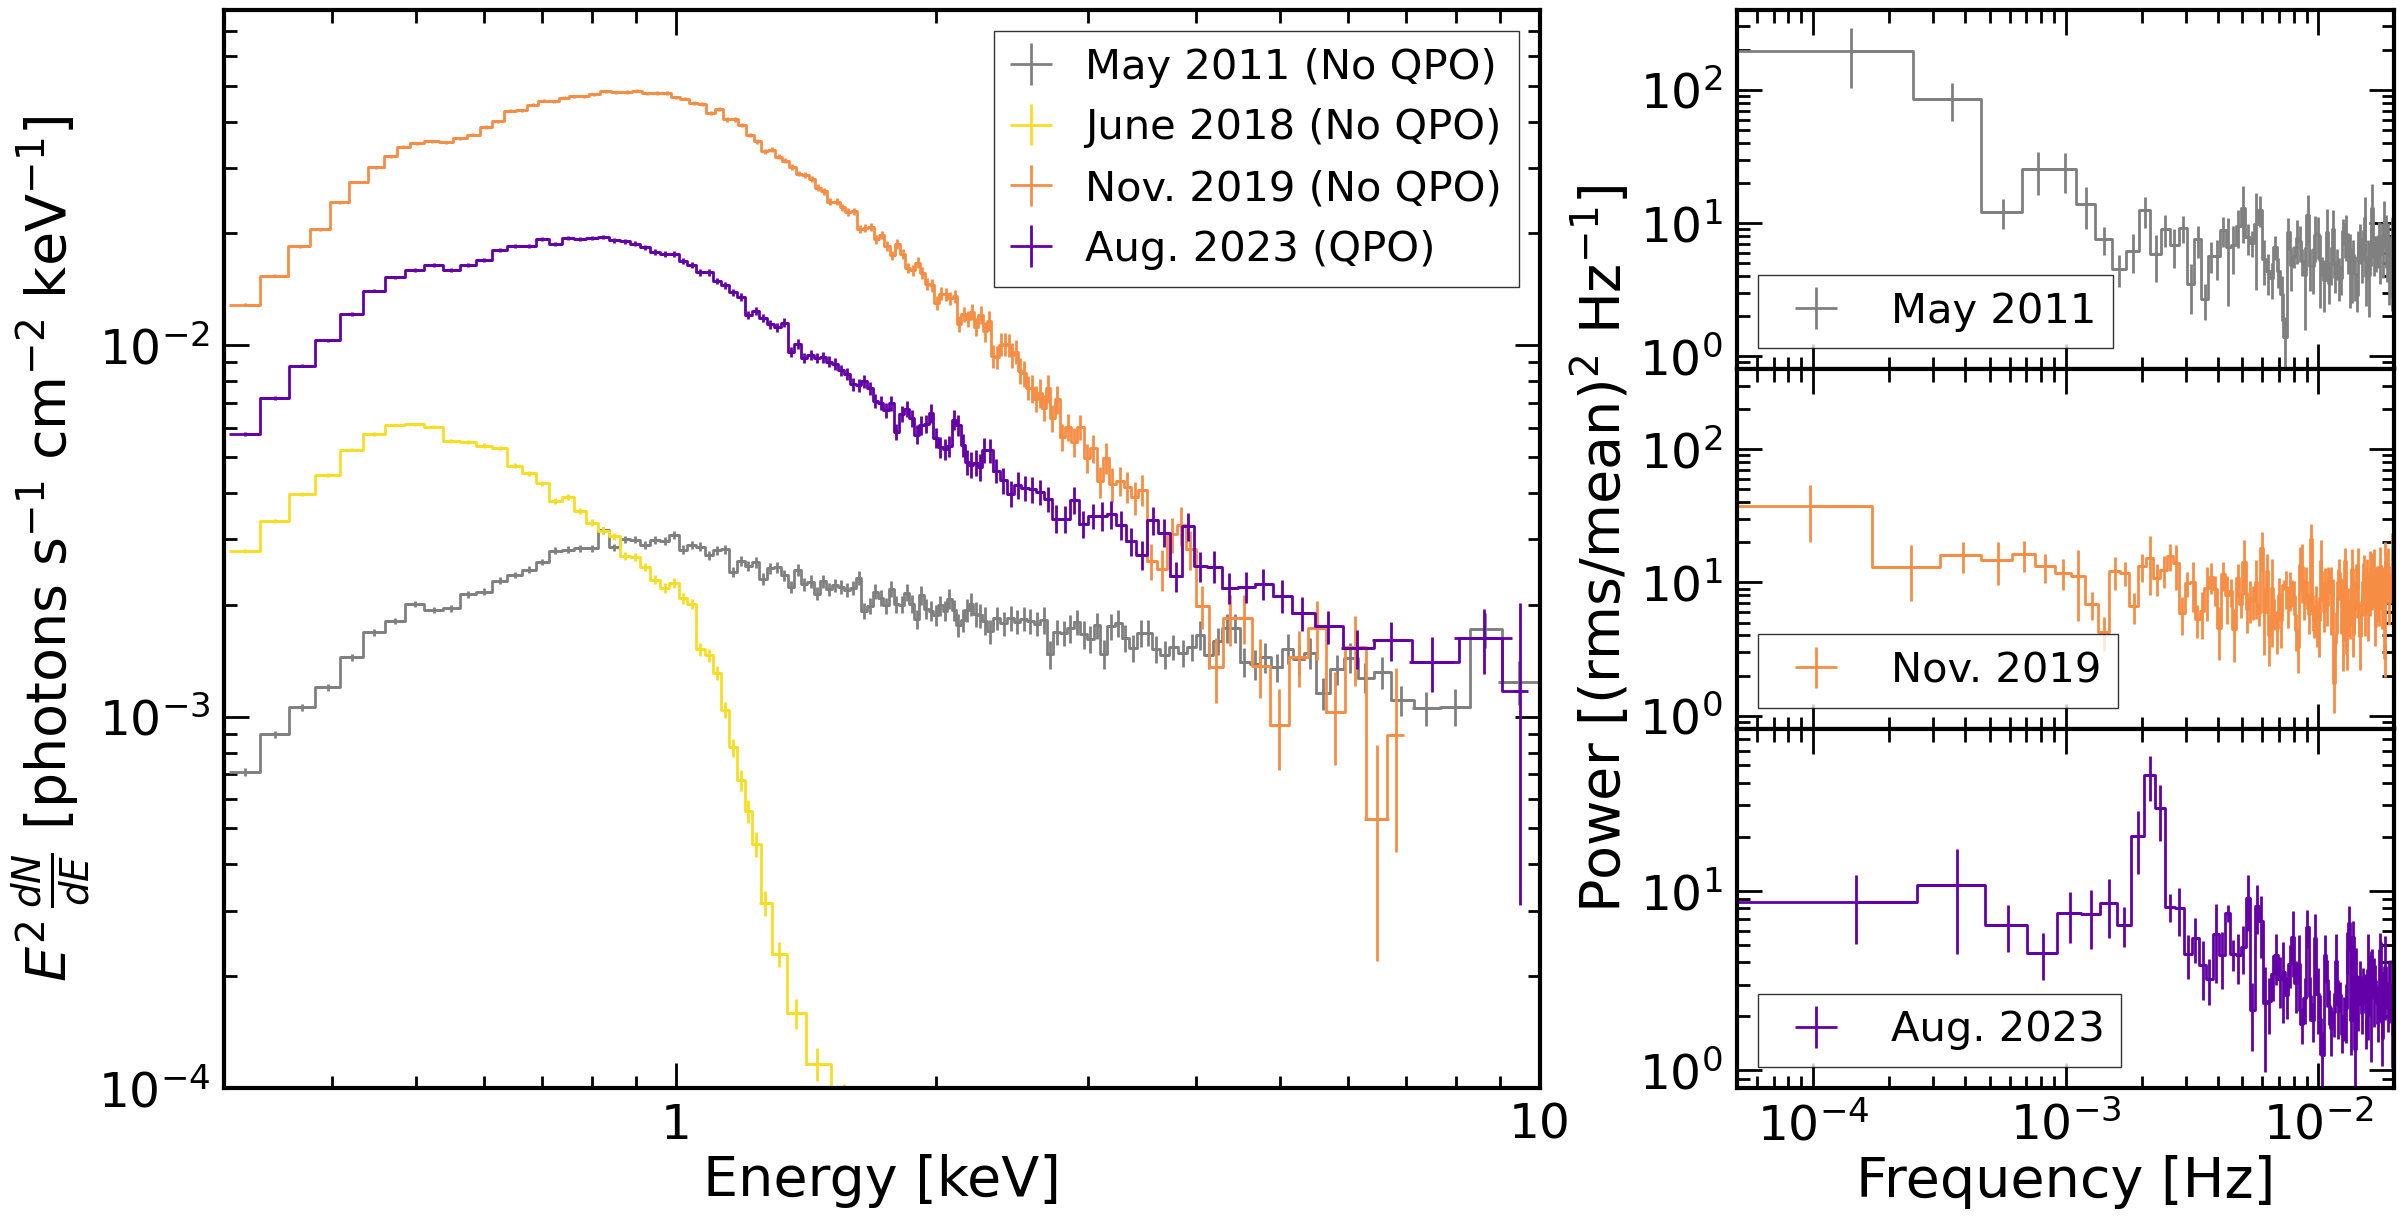

In [7]:
# load in spectral data
spec_data = '../data/specplot/eeuf_gamma0_sample.dat'
spec = pd.read_table(spec_data, 
                     delim_whitespace=True, header=2,
                     names=['energy', 'del_energy', 'cts', 'cts_err', 'mod'])
filter = spec['energy'].isin(["NO"])
locNO = np.where(filter)[0]

n_spec = locNO.size + 1

use_inds_new = np.array([0,1,4,10])

# set up figure
mosaic = """
    AB
    AC
    AD
    """
fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(28,14), width_ratios=[1,0.5], gridspec_kw={'hspace':0, 'wspace':0.2})
ax = axs['A']

for j in range(n_spec):

    # temporary array to store data for the jth spectrum
    # for the first data set
    if (j == 0):
        data = spec[0:locNO[0]].astype(float)
    # for the last data set
    elif (j == n_spec-1):
        data = spec[locNO[j-1]+1:].astype(float)
    # for all data sets in between
    else:
        data = spec[locNO[j-1]+1:locNO[j]].astype(float)

    # for xmm data 
    energy = data['energy']
    del_energy = data['del_energy']
    cts = data['cts']
    cts_err = data['cts_err']

    if j == 3:
        add = ' (QPO)'
    else:
        add = ' (No QPO)'

    ax.errorbar(energy, cts, \
                xerr=del_energy, yerr=cts_err, \
                fmt='o', color=save_color[use_inds_new[j]], ms=0, capsize=0, \
                lw=2, ecolor=save_color[use_inds_new[j]],
                label=print_times[use_inds_new[j]]+add)
    ax.step(energy, cts, color=save_color[use_inds_new[j]], lw=2, where='mid')

ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'$E^2 \, \frac{dN}{dE}$ [photons s$^{-1}$ cm$^{-2}$ keV$^{-1}$]')
ax.legend(loc='upper right', handlelength=1)
ax.set_xlim(0.3,10)
ax.set_ylim(1e-4,8e-2)

labs = ['B', 'C', 'D']

for i in range(len(use_inds)):
    ax = axs[labs[i]]

    time, rate, err, freq, power, freq_err, power_err, f_min, f_max, _, _ = make_psd(obs[use_inds[i]], data_path, emin, emax, tbin, n=6)

    color = save_color[use_inds[i]]
    ax.errorbar(freq, power, xerr=freq_err, yerr=power_err, fmt='o', ms=0, color=color, mew=2, mec='k', capsize=0, lw=2, label=print_times[use_inds[i]])
    ax.step(freq, power, color=color, lw=2, where='mid')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='lower left')
    if i == 2:
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylim(0.8,80)
    else:
        ax.set_xticklabels([])
        ax.set_ylim(0.8,400)
    if i == 1:
        ax.set_ylabel(r'Power [(rms/mean)$^2$ Hz$^{-1}$]')
    ax.set_xlim(5e-5,2e-2)
    
fig.align_ylabels()

if save: 
    plt.savefig(fig_path+'1ES_spec_psds.pdf', bbox_inches='tight')

### Figure 4

/Users/megan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


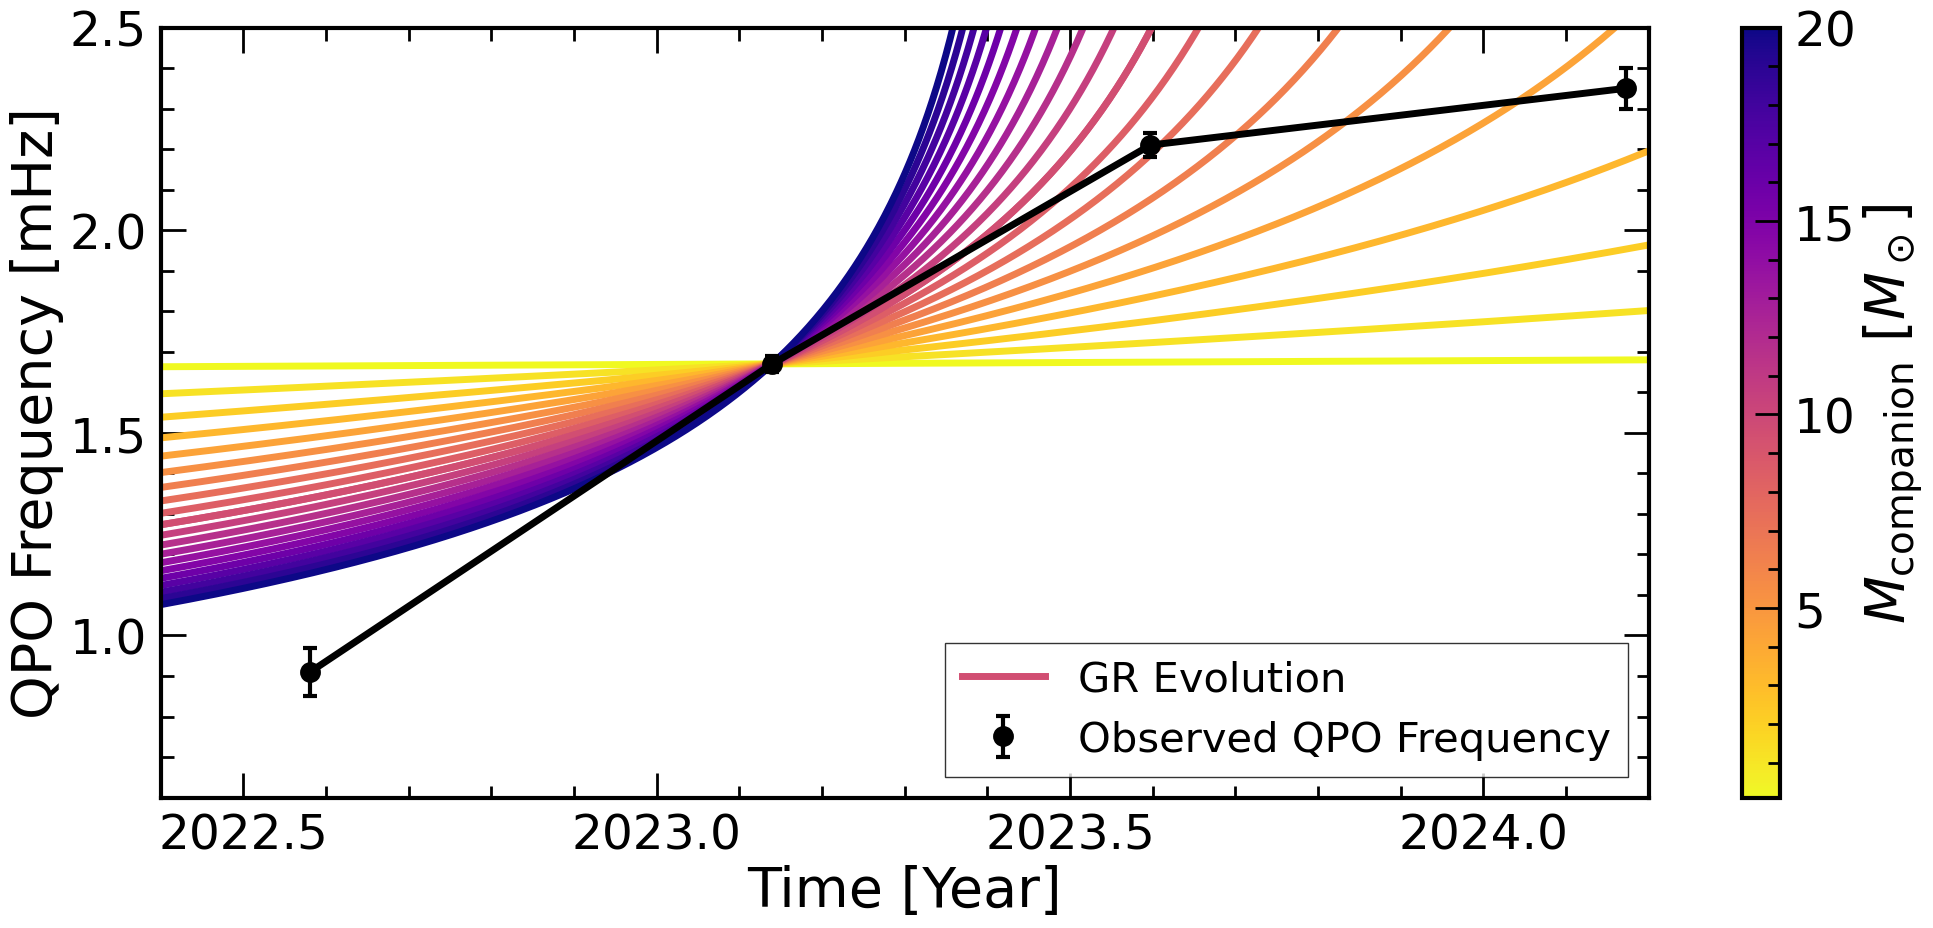

In [8]:
fig, ax = plt.subplots(figsize=(24,10), ncols=1, gridspec_kw={'wspace':0.2})

# evolution expected from from GR alone 
M1 = 1.38e6 * const.M_sun
def f_GR(t, t0, f0, M2):
    alpha = (-96 / 5) * (const.G**(5/3) / const.c**5) * (M1 * M2 / (M1 + M2)**(1/3)) * (2 * np.pi)**(8/3)
    return (f0**(-8/3) + ((8 / 3) * alpha * (t - t0)))**(-3/8)
t_grid = np.linspace(2022.4, 2024.2, 1000) * u.year
t0 = qpo_times[1] * u.year
f0 = qpo_freq[1] * u.mHz

# with a range of companion masses
M2 = np.linspace(0.1, 20, 20) * const.M_sun
cmap_GR = plt.cm.plasma_r  # Choose a colormap
norm_GR = Normalize(vmin=min((M2 / const.M_sun).value), vmax=max((M2 / const.M_sun).value))
colors_GR = cmap_GR(norm_GR((M2 / const.M_sun).value))
for i in range(len(M2)):
    ax.plot(t_grid, f_GR(t_grid, t0, f0, M2[i]).to(u.mHz), '-', lw=5, color=colors_GR[i])
    if i == len(M2)/2-1:
        ax.plot(t_grid, f_GR(t_grid, t0, f0, M2[i]).to(u.mHz), '-', lw=5, color=colors_GR[i], label='GR Evolution')

# add data on top
ax.errorbar(qpo_times, qpo_freq, yerr=qpo_freq_err, 
            fmt='o', ms=12, lw=3, capsize=5, color='k', mew=3, label='Observed QPO Frequency')
ax.plot(qpo_times, qpo_freq, '-', color='k', lw=5)
ax.set_ylabel('QPO Frequency [mHz]')
ax.set_xlabel('Time [Year]')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.set_xlim(2022.4,2024.2)
ax.set_ylim(0.6,2.5)
ax.legend(loc='lower right')

# add color bar
sm_GR = plt.cm.ScalarMappable(cmap=cmap_GR, norm=norm_GR)
cbar = fig.colorbar(sm_GR, ax=ax)
cbar.set_label(r'$M_\mathrm{companion}$ [$M_\odot$]')

if save: 
    plt.savefig(fig_path+'1ES_QPOfreqevolution_withGR.pdf', bbox_inches='tight')
# plt.savefig(fig_path+'1ES_QPOfreqevolution_withoutGR.pdf', bbox_inches='tight')

### Supp. Fig. 1

/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_80900/837612601.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(Time(nicer_time, format='mjd').decimalyear, tot_rate[good] * ct_to_flux, c=colors, cmap=cmap, edgecolor='k', s=200, lw=1, label='NICER', alpha=1, zorder=9)


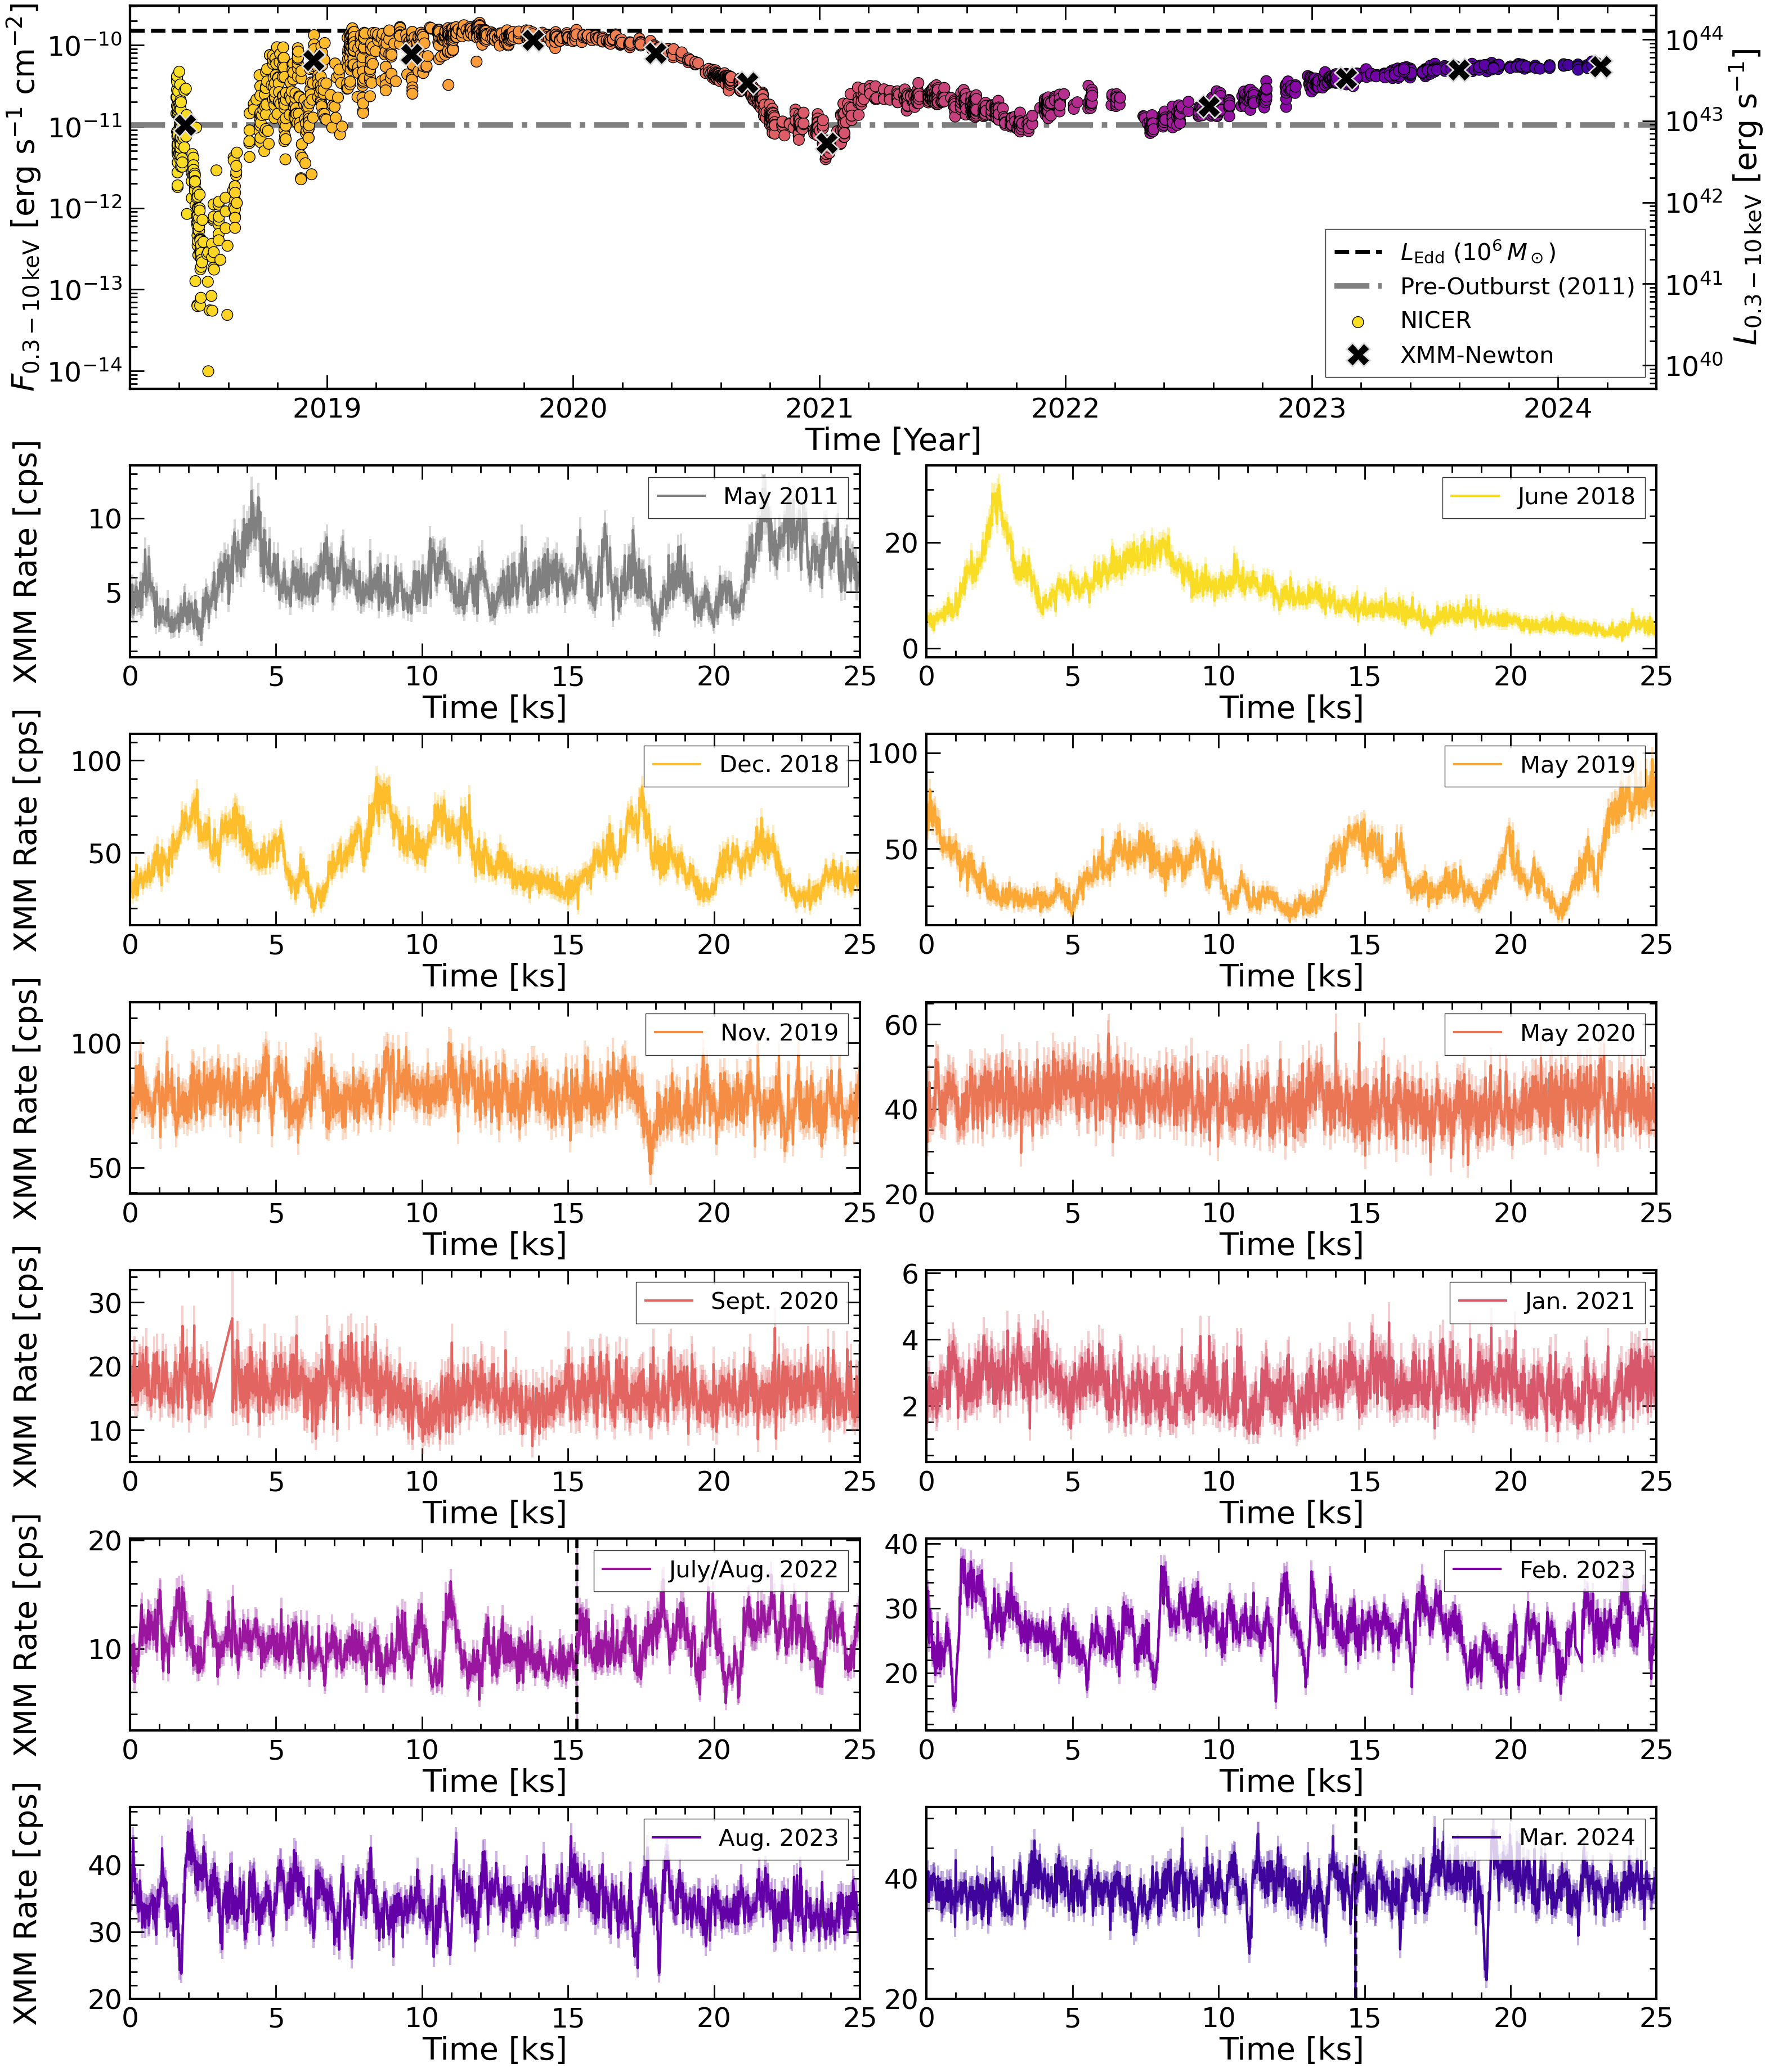

In [25]:
mosaic = """
    AAAA
    BBCC
    DDEE
    FFGG
    HHII
    JJKK
    LLMM
    """

fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(35,46), height_ratios=[2, 1, 1, 1, 1, 1, 1], gridspec_kw={'hspace':0.35})

# top panel
ax = axs['A']
ct_to_flux = 1.088e-12 # gamma = 3, nH = 6e20, 0.3-10 keV
ax.axhline(((1.3e44 * u.erg / u.s) / (4 * np.pi * d_L.to(u.cm).value**2)).value, color='k', ls='--', lw=5, label=r'$L_\mathrm{Edd}$ ($10^6 \, M_\odot$)')
ax.axhline((6.8+3.7) * 1e-12, color='grey', ls='-.', lw=7, label='Pre-Outburst (2011)')
ax.set_ylabel(r'$F_\mathrm{0.3-10 \, keV}$ [erg s$^{-1}$ cm$^{-2}$]')
ax.set_xlabel('Time [Year]')
ax.set_xlim(2018.2,2024.4)

# color map based on time
sc = ax.scatter(Time(nicer_time, format='mjd').decimalyear, tot_rate[good] * ct_to_flux, c=colors, cmap=cmap, edgecolor='k', s=200, lw=1, label='NICER', alpha=1, zorder=9)

# add xmm data
ax.plot(xmm_time, xmm_flux, 'X', color='k', ms=30, mew=2, mec='gainsboro', label='XMM-Newton', zorder=10)

# set up the rest of the figure
ax.legend(loc='lower right')
ax.set_yscale('log')
axr = ax.twinx()
axr.set_ylim(ax.get_ylim()[0] * 4 * np.pi * d_L.to(u.cm).value**2, ax.get_ylim()[-1] * 4 * np.pi * d_L.to(u.cm).value**2)
axr.set_yscale('log')
axr.set_ylabel(r'$L_\mathrm{0.3-10 \, keV}$ [erg s$^{-1}$]')

labs = ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
emin = 0.3
emax = 10.
tbin = 20

for i,alp in enumerate(labs):

    ax = axs[alp]

    # load in the data
    lc_file = "PN_"+obs[i]+"_"+str(emin)+"-"+str(emax)+"_"+str(tbin)+"s.lc"
    hdu = fits.open(data_path+lc_file)
    data = hdu[1].data
    data = data[~np.isnan(data['RATE'])]
    time = data['TIME']-data['TIME'][0]
    rate = data['RATE']
    err = data['ERROR']

    color = save_color[i]
    ax.errorbar(time / 1e3, rate, yerr=err, fmt='-', ms=10, color=color, mew=1.5, mec='k', capsize=0, lw=3, alpha=0.3)
    ax.plot(time / 1e3, rate, '-', color=color, lw=3, label=print_times[i]) 
    ax.set_xlim(0,25)
    ax.set_xlabel('Time [ks]')
    if np.mod(i,2) == 0:
        ax.set_ylabel('XMM Rate [cps]')
    ax.legend(loc='upper right', fontsize=30)

    if obs[i] == '0843270101':
        ax.set_ylim(10,110)
    elif obs[i] == '0932392001' or obs[i] == '0863230101':
        ax.set_ylim(20,)
    elif obs[i] == '0863230201':
        ax.set_ylim(5,35)
    elif obs[i] == '0931791401':
        ax.set_ylim(20,)

    # for > 1 obs, add the others
    if obs[i] == '0902590201' or obs[i] == '0932392001':
        
        tstop = max(time)
        ax.axvline(tstop / 1e3, color='k', ls='--', lw=4)
        if obs[i] == '0902590201':
            obs_2 = '0902590301'
        elif obs[i] == '0932392001':
            obs_2 = '0932392101'

        lc_file = "PN_"+obs_2+"_"+str(emin)+"-"+str(emax)+"_"+str(tbin)+"s.lc"
        hdu = fits.open(data_path+lc_file)
        data = hdu[1].data
        data = data[~np.isnan(data['RATE'])]
        time = data['TIME']-data['TIME'][0] + tstop
        rate = data['RATE']
        err = data['ERROR']

        ax.errorbar(time / 1e3, rate, yerr=err, fmt='-', ms=10, color=color, mew=1.5, mec='k', capsize=0, lw=3, alpha=0.3)
        ax.plot(time / 1e3, rate, '-', color=color, lw=3, label=print_times[i]) 

fig.align_ylabels()

if save: 
    plt.savefig(fig_path+'1ES_lightcurves_xmmzoom.pdf', bbox_inches='tight')

### Supp. Fig. 2

In [10]:
def broadband_plot(fig, axs, obs, data_path, emin, emax, tbin=20, n=0, nwalkers=32, nsteps=55000, nburn=5000, use_name=None, label=True):

    # get the psd that you want to plot
    _, _, _, freq, power, _, _, f_min, f_max, _, _ = make_psd(obs, data_path, emin, emax, tbin, n)

    mcmc_path = 'broadband_mcmcs/'

    # plot
    ax = axs[0]
    grid = np.linspace(f_min, f_max, 1000)
    ax.step(freq, power, color='k', lw=2, label='ObsID '+obs, where='mid')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if label:
        ax.set_ylabel(r'Power [(rms/mean)$^2$ Hz$^{-1}$]', fontsize=45)
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(8e-2,3e2)

    # power law model
    if not use_name is None:
        fname = mcmc_path+'broadband_'+use_name+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_powerlaw.h5'
    else:
        fname = mcmc_path+'broadband_'+obs+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_powerlaw.h5'
    backend = emcee.backends.HDFBackend(fname)

    # if we haven't run the MCMC, there's a problem
    if not os.path.exists(fname):
        raise FileNotFoundError

    n_rand = 100
    samples_pl = backend.get_chain(discard=nburn, flat=True)
    fit_pl = np.zeros((len(grid),n_rand))
    fit_binned_pl = np.zeros((len(freq),n_rand))
    for i in range(n_rand):
        use_N0, use_ahi, use_c = samples_pl[i,:]
        fit_pl[:,i] = powerlaw(grid, use_N0, use_ahi, use_c)
        fit_binned_pl[:,i] = powerlaw(freq, use_N0, use_ahi, use_c)
    med_fit_pl = np.median(fit_pl, axis=1)
    med_fit_pl_16 = np.percentile(fit_pl, 16, axis=1)
    med_fit_pl_84 = np.percentile(fit_pl, 84, axis=1)
    med_fit_binned_pl = np.median(fit_binned_pl, axis=1)
    ax.plot(grid, med_fit_pl, color=save_color[4], lw=5, ls='--', label='Power-Law Model')
    ax.fill_between(grid, med_fit_pl_16, med_fit_pl_84, color=save_color[4], alpha=0.3)

    # lorentzian model
    if not use_name is None:
        fname = mcmc_path+'broadband_'+use_name+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_lorentzian.h5'
    else:
        fname = mcmc_path+'broadband_'+obs+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_lorentzian.h5'
    backend = emcee.backends.HDFBackend(fname)

    # if we haven't run the MCMC, there's a problem
    if not os.path.exists(fname):
        raise FileNotFoundError

    n_rand = 100
    samples_lor = backend.get_chain(discard=nburn, flat=True)
    fit_lor = np.zeros((len(grid),n_rand))
    fit_binned_lor = np.zeros((len(freq),n_rand))
    for i in range(n_rand):
        use_R, use_delta, use_c = samples_lor[i,:]
        fit_lor[:,i] = lorentzian(grid, use_R, use_delta, use_c)
        fit_binned_lor[:,i] = lorentzian(freq, use_R, use_delta, use_c)
    med_fit_lor = np.median(fit_lor, axis=1)
    med_fit_lor_16 = np.percentile(fit_lor, 16, axis=1)
    med_fit_lor_84 = np.percentile(fit_lor, 84, axis=1)
    med_fit_binned_lor = np.median(fit_binned_lor, axis=1)
    ax.plot(grid, med_fit_lor, color=save_color[-2], lw=5, ls='--', label='Lorentzian Model')
    ax.fill_between(grid, med_fit_lor_16, med_fit_lor_84, color=save_color[-2], alpha=0.3)
    ax.legend(loc='lower left')

    ax = axs[1]
    ax.axhline(1, color=save_color[4], ls='--', lw=5)
    ax.step(freq, power / med_fit_binned_pl, color='k', lw=2, where='mid')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if label:
        ax.set_ylabel('D / M', fontsize=45)
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(3e-2,2e1)
    ax = axs[2]
    ax.axhline(1, color=save_color[-2], ls='--', lw=5)
    ax.step(freq, power / med_fit_binned_lor, color='k', lw=2, where='mid')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if label:
        ax.set_ylabel('D / M', fontsize=45)
    ax.set_xlabel('Frequency [Hz]', fontsize=50)
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(3e-2,2e1)

YOU HAVE A SERIOUS PROBLEM. YOUR DATA IS NOT CONTINUOUS. YOU ARE LINEARLY INTERPOLATING THE GAPS. MAKE SURE THAT THESE ARE NOT TOO LONG.


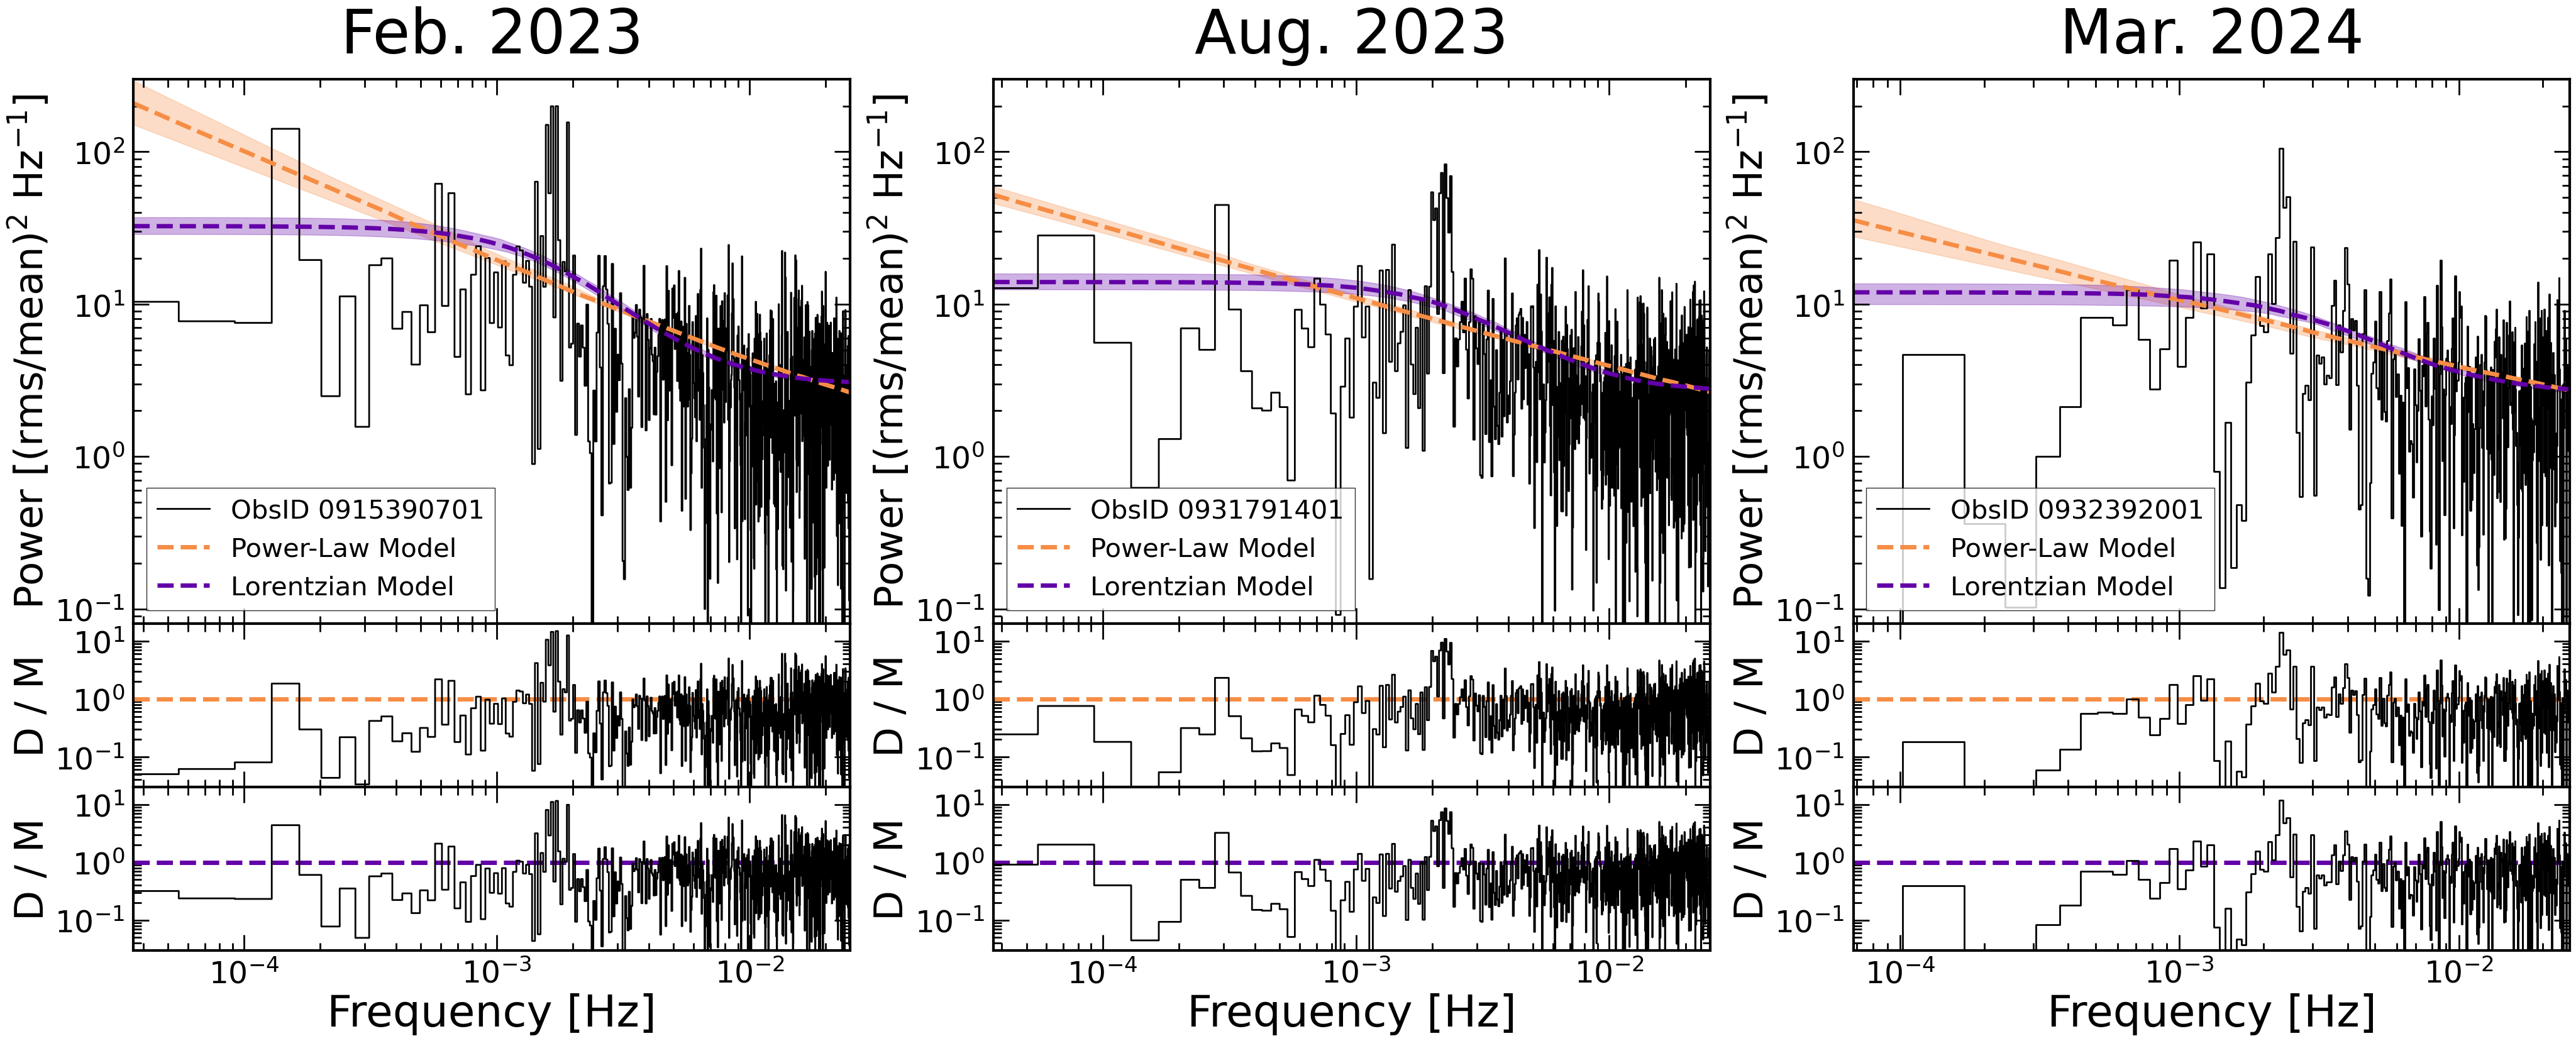

In [11]:
fig, axs = plt.subplots(figsize=(50,18), nrows=3, ncols=3, gridspec_kw={'hspace':0, 'wspace':0.2, 'height_ratios':[1,0.3,0.3]})
broadband_plot(fig, axs[:,0], '0915390701', data_path, 2., 10., tbin=20, n=0)
broadband_plot(fig, axs[:,1], '0931791401', data_path, 2., 10., tbin=20, n=0)
broadband_plot(fig, axs[:,2], '0932392001', data_path, 2., 10., tbin=20, n=0)
axs[0,0].set_title('Feb. 2023', fontsize=70, pad=30)
axs[0,1].set_title('Aug. 2023', fontsize=70, pad=30)
axs[0,2].set_title('Mar. 2024', fontsize=70, pad=30)

if save: 
    plt.savefig(fig_path+'1ES_broadbandPSDfits.pdf', bbox_inches='tight')

### Supp. Fig. 3

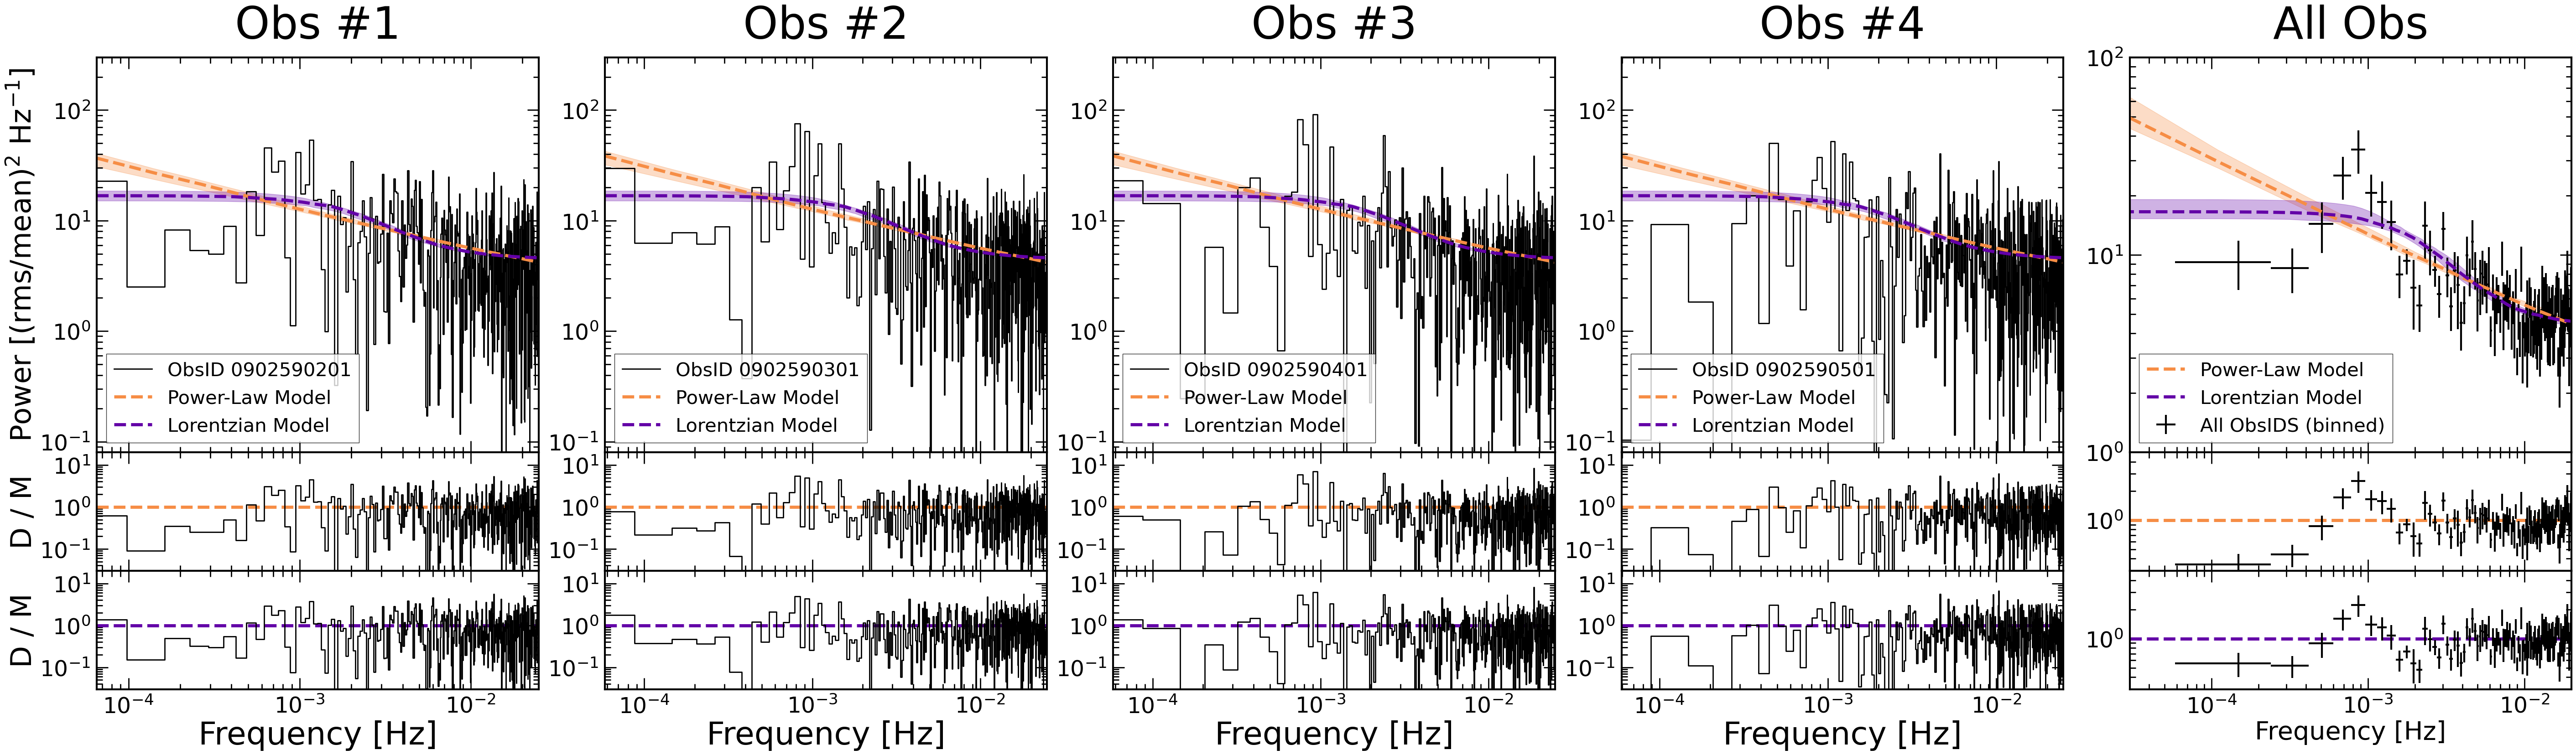

In [12]:
# same thing but for the multiple observations from july-aug 2022
obs_aug2022 = np.array(['0902590201', '0902590301', '0902590401', '0902590501'])

# fig, axs = plt.subplots(figsize=(15,18), nrows=3, gridspec_kw={'hspace':0, 'height_ratios':[1,0.3,0.3]})
fig, axs = plt.subplots(figsize=(70,18), nrows=3, ncols=5, gridspec_kw={'hspace':0, 'wspace':0.15, 'height_ratios':[1,0.3,0.3]})
broadband_plot(fig, axs[:,0], '0902590201', data_path, 2., 10., tbin=20, n=0, use_name='Aug2022')
broadband_plot(fig, axs[:,1], '0902590301', data_path, 2., 10., tbin=20, n=0, use_name='Aug2022', label=False)
broadband_plot(fig, axs[:,2], '0902590401', data_path, 2., 10., tbin=20, n=0, use_name='Aug2022', label=False)
broadband_plot(fig, axs[:,3], '0902590501', data_path, 2., 10., tbin=20, n=0, use_name='Aug2022', label=False)

axs[0,0].set_title('Obs #1', fontsize=70, pad=30)
axs[0,1].set_title('Obs #2', fontsize=70, pad=30)
axs[0,2].set_title('Obs #3', fontsize=70, pad=30)
axs[0,3].set_title('Obs #4', fontsize=70, pad=30)
axs[0,4].set_title('All Obs', fontsize=70, pad=30)

time, rate, err, freq, power, freq_err, power_err, f_min, f_max, tstarts, true_time = make_psd(obs_aug2022, data_path, 2., 10., tbin, 12)
axs[0,4].errorbar(freq, power, xerr=freq_err, yerr=power_err, fmt='o', ms=0, color='k', mew=1.5, mec='k', capsize=0, lw=3, label='All ObsIDS (binned)')
axs[0,4].set_xscale('log')
axs[0,4].set_yscale('log')
axs[0,4].set_ylim(1,100)

# grab the models to overplot
emin = 2.
emax = 10.
use_name = 'Aug2022'
mcmc_path = 'broadband_mcmcs/'
grid = np.linspace(1e-5, 1e-1, 1000)
nburn = 500
# power law
fname = mcmc_path+'broadband_'+use_name+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_powerlaw.h5'
backend = emcee.backends.HDFBackend(fname)
n_rand = 100
samples_pl = backend.get_chain(discard=nburn, flat=True)
fit_pl = np.zeros((len(grid),n_rand))
fit_binned_pl = np.zeros((len(freq),n_rand))
for i in range(n_rand):
    use_N0, use_ahi, use_c = samples_pl[i,:]
    fit_pl[:,i] = powerlaw(grid, use_N0, use_ahi, use_c)
    fit_binned_pl[:,i] = powerlaw(freq, use_N0, use_ahi, use_c)
med_fit_pl = np.median(fit_pl, axis=1)
med_fit_pl_16 = np.percentile(fit_pl, 16, axis=1)
med_fit_pl_84 = np.percentile(fit_pl, 84, axis=1)
med_fit_binned_pl = np.median(fit_binned_pl, axis=1)
axs[0,4].plot(grid, med_fit_pl, color=save_color[4], lw=5, ls='--', label='Power-Law Model')
axs[0,4].fill_between(grid, med_fit_pl_16, med_fit_pl_84, color=save_color[4], alpha=0.3)
# lorentzian
fname = mcmc_path+'broadband_'+use_name+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_lorentzian.h5'
backend = emcee.backends.HDFBackend(fname)
n_rand = 100
samples_lor = backend.get_chain(discard=nburn, flat=True)
fit_lor = np.zeros((len(grid),n_rand))
fit_binned_lor = np.zeros((len(freq),n_rand))
for i in range(n_rand):
    use_R, use_delta, use_c = samples_lor[i,:]
    fit_lor[:,i] = lorentzian(grid, use_R, use_delta, use_c)
    fit_binned_lor[:,i] = lorentzian(freq, use_R, use_delta, use_c)
med_fit_lor = np.median(fit_lor, axis=1)
med_fit_lor_16 = np.percentile(fit_lor, 16, axis=1)
med_fit_lor_84 = np.percentile(fit_lor, 84, axis=1)
med_fit_binned_lor = np.median(fit_binned_lor, axis=1)
axs[0,4].plot(grid, med_fit_lor, color=save_color[-2], lw=5, ls='--', label='Lorentzian Model')
axs[0,4].fill_between(grid, med_fit_lor_16, med_fit_lor_84, color=save_color[-2], alpha=0.3)
axs[0,4].legend(loc='lower left')
axs[0,4].set_xlim(3e-5,2e-2)

ax = axs[1,4]
ax.axhline(1, color=save_color[4], ls='--', lw=5)
ax.errorbar(freq, power / med_fit_binned_pl, xerr=freq_err, yerr=power_err / med_fit_binned_pl, fmt='o', ms=0, color='k', mew=1.5, mec='k', capsize=0, lw=3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(3e-5,2e-2)
ax.set_ylim(0.3,5)

ax = axs[2,4]
ax.axhline(1, color=save_color[-2], ls='--', lw=5)
ax.errorbar(freq, power / med_fit_binned_lor, xerr=freq_err, yerr=power_err / med_fit_binned_lor, fmt='o', ms=0, color='k', mew=1.5, mec='k', capsize=0, lw=3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(3e-5,2e-2)
ax.set_ylim(0.3,5)
ax.set_xlabel('Frequency [Hz]')
    
if save: 
    plt.savefig(fig_path+'1ES_broadbandPSDfits_aug2022.pdf', bbox_inches='tight')

### Supp. Fig. 4

YOU HAVE A SERIOUS PROBLEM. YOUR DATA IS NOT CONTINUOUS. YOU ARE LINEARLY INTERPOLATING THE GAPS. MAKE SURE THAT THESE ARE NOT TOO LONG.
YOU HAVE A SERIOUS PROBLEM. YOUR DATA IS NOT CONTINUOUS. YOU ARE LINEARLY INTERPOLATING THE GAPS. MAKE SURE THAT THESE ARE NOT TOO LONG.
YOU HAVE A SERIOUS PROBLEM. YOUR DATA IS NOT CONTINUOUS. YOU ARE LINEARLY INTERPOLATING THE GAPS. MAKE SURE THAT THESE ARE NOT TOO LONG.


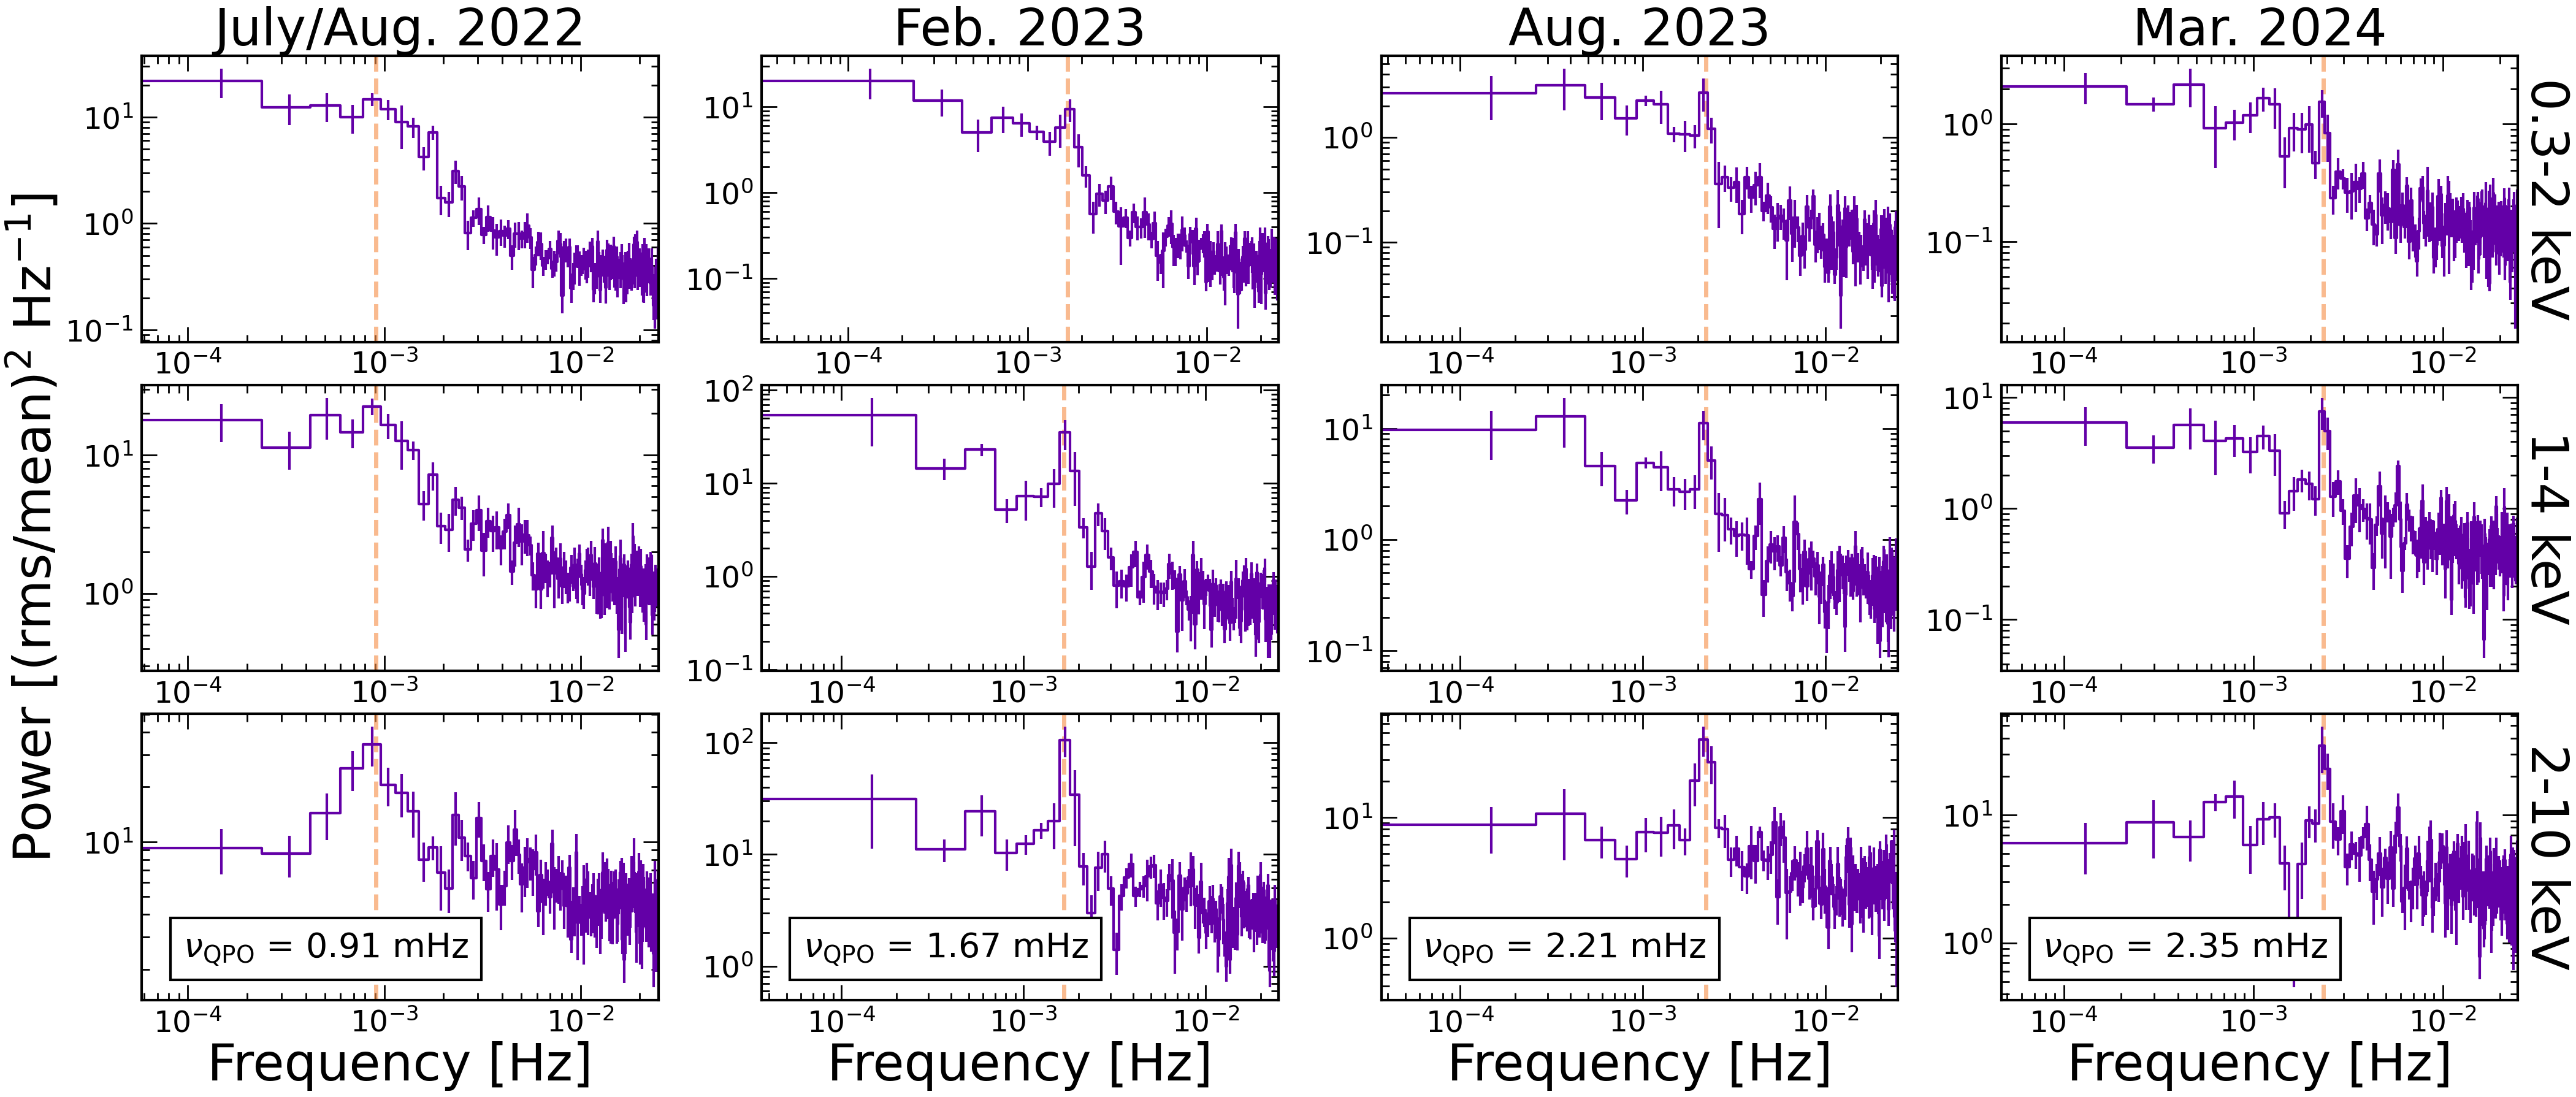

In [13]:
mosaic = """
    abcd
    efgh
    ijkl
    """

fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(50,20), gridspec_kw={'hspace':0.15, 'wspace':0.2})

n = 6
emins = np.array([0.3, 1., 2.])
emaxs = np.array([2., 4., 10.])
color = save_color[-2]
qpo_labs = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'])

for i,alp in enumerate(qpo_labs):
    ax = axs[alp]

    which_en = i // 4
    which_obs = np.mod(i,4)

    # first add vertical line @ qpo freq so it's behind everything else
    ax.axvline(qpo_freq[which_obs] / 1e3, lw=5, ls='--', color=save_color[4], alpha=0.6)

    emin = emins[which_en]
    emax = emaxs[which_en]
    if qpo_obs[which_obs] == '0902590201': 
        time, rate, err, freq, power, freq_err, power_err, f_min, f_max, _, _ = make_psd(['0902590201', '0902590301', '0902590401', '0902590501'], 
                                                                                         data_path, emin, emax, tbin, 2*n)
    elif qpo_obs[which_obs] == '0932392001': 
        time, rate, err, freq, power, freq_err, power_err, f_min, f_max, _, _ = make_psd(['0932392001', '0932392101'], 
                                                                                         data_path, emin, emax, tbin, n)
    else:    
        time, rate, err, freq, power, freq_err, power_err, f_min, f_max, _, _ = make_psd(qpo_obs[which_obs], data_path, emin, emax, tbin, n)

    ax.errorbar(freq, power, xerr=freq_err, yerr=power_err, fmt='o', ms=0, color=color, capsize=0, lw=3)
    ax.step(freq, power, color=color, lw=3, where='mid')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(f_min, f_max)

    if which_en == 0:
        ax.set_title(qpo_print_times[which_obs], fontsize=60)
    if which_en == 2:
        ax.set_xlabel('Frequency [Hz]', fontsize=60)
        ax.text(0.08, 0.15, r'$\nu_\mathrm{QPO}$ = '+str(np.round(qpo_freq[which_obs],2))+' mHz', transform=ax.transAxes, 
                bbox=dict(facecolor='w', alpha=1, edgecolor='k', lw=3, pad=15), fontsize=40)

    if which_obs == 0 and which_en == 1:
        ax.set_ylabel(r'Power [(rms/mean)$^2$ Hz$^{-1}$]', fontsize=60)
    if which_obs == 3:
        if emins[which_en] == 0.3:
            use_emin = '0.3'
        else:
            use_emin = str(int(emins[which_en]))
        ax.set_ylabel(use_emin+'-'+str(int(emaxs[which_en]))+' keV', rotation=-90, labelpad=-700, fontsize=60)

fig.align_ylabels()

if save: 
    plt.savefig(fig_path+'1ES_PSDs_energydependence.pdf', bbox_inches='tight')

### Supp. Fig. 5

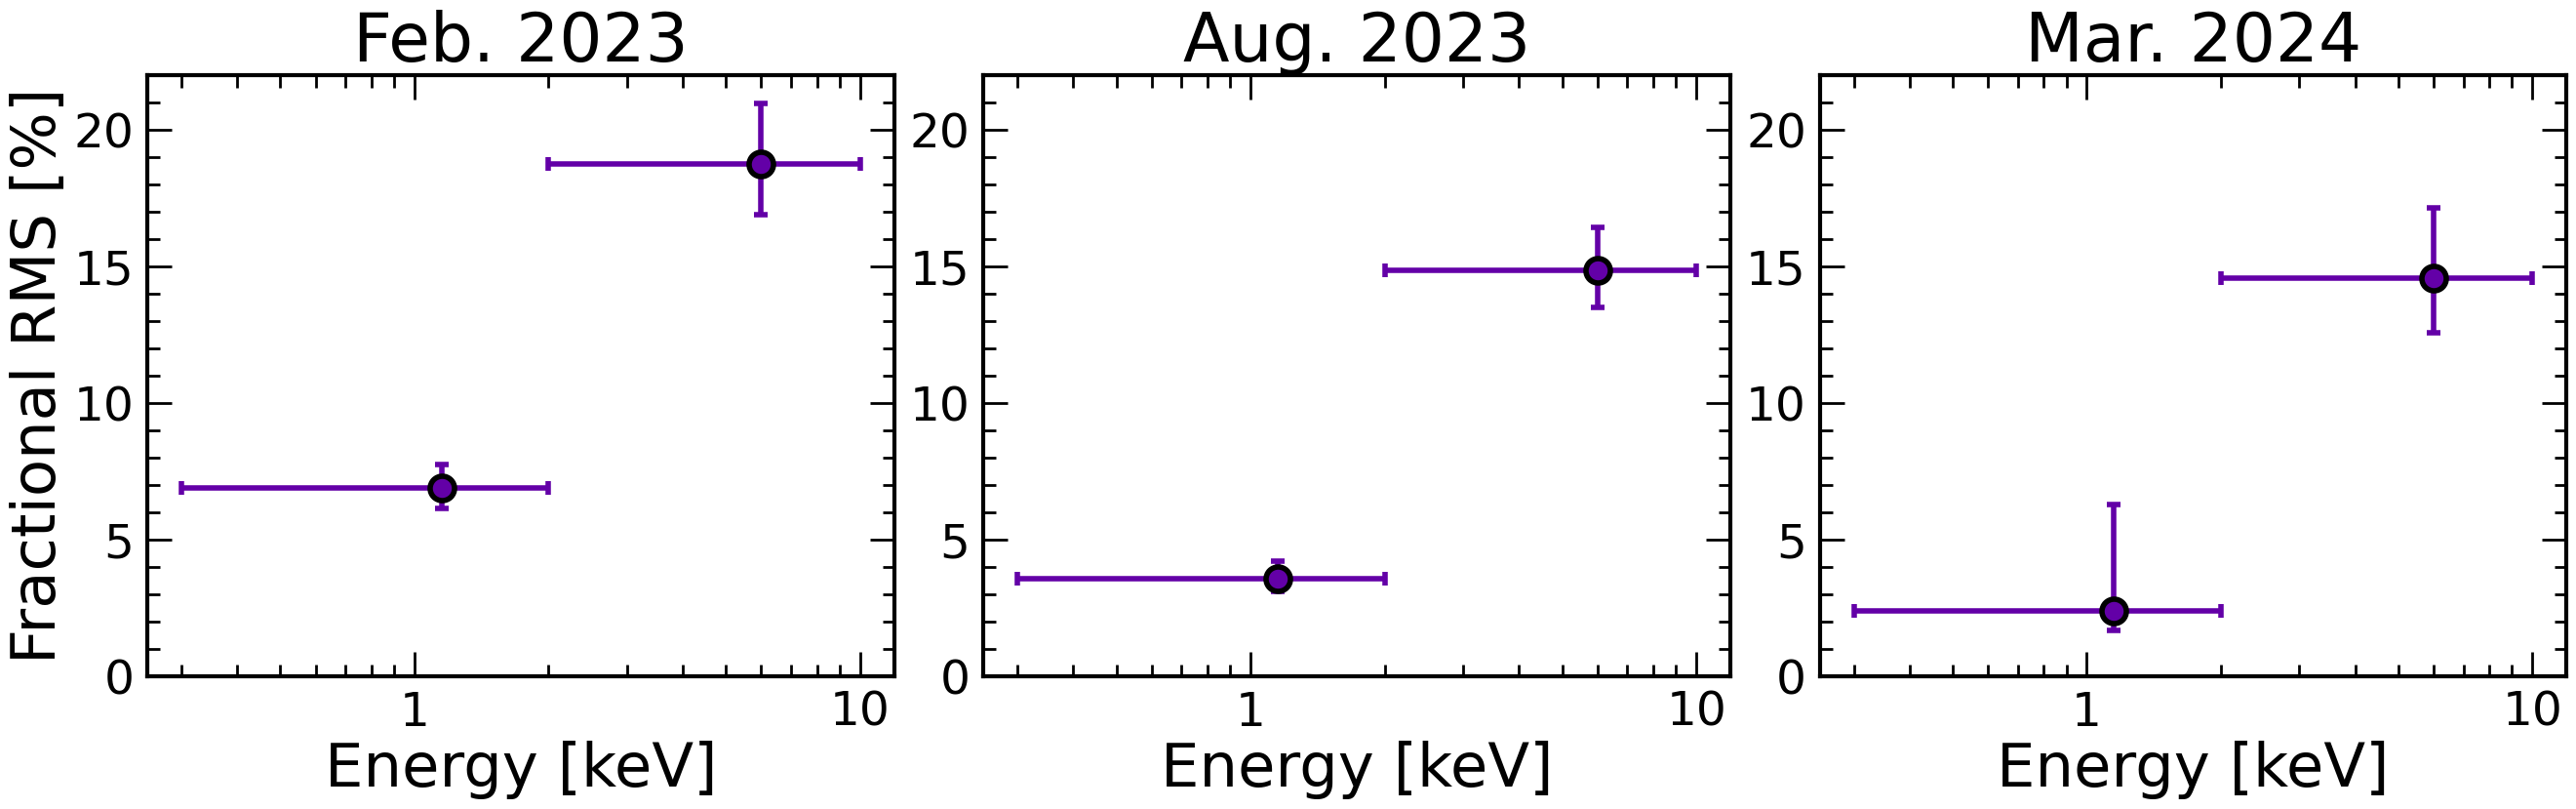

In [14]:
fig, axs = plt.subplots(figsize=(32,8), ncols=3, gridspec_kw={'wspace':0.12})

use_obs = np.array(['0915390701', '0931791401', '0932392001'])
use_times = np.array(['Feb. 2023', 'Aug. 2023', 'Mar. 2024'])
use_emin = np.array([2., 0.3])
use_emax = np.array([10., 2.])

for i,obsid in enumerate(use_obs):

    ax = axs[i]
    if i == 0:
        ax.set_ylabel('Fractional RMS [%]', fontsize=45)

    for j,emin in enumerate(use_emin):
        emax = use_emax[j]

        rms = np.load(mcmc_path_qpo+'rms_'+str(emin)+'-'+str(emax)+'keV.npy')

        # ax.errorbar((emin + emax) / 2, rms[i,0] * 100, xerr=(emax - emin) / 2, yerr=[[rms[i,1] * 100],[rms[i,2] * 100]],
        #             fmt='o', color=save_color[-2], ms=0, lw=5)
        ax.errorbar((emin + emax) / 2, rms[i,0] * 100, xerr=(emax - emin) / 2, yerr=[[rms[i,1] * 100],[rms[i,2] * 100]],
                    fmt='o', ms=18, lw=4, capsize=5, color=save_color[-2], mew=4, mec='k')
           
    ax.set_title(use_times[i], fontsize=50)
    ax.set_xlabel('Energy [keV]', fontsize=45)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.set_ylim(0,22)

if save: 
    plt.savefig(fig_path+'1ES_rms.pdf', bbox_inches='tight')

### Supp. Fig. 6

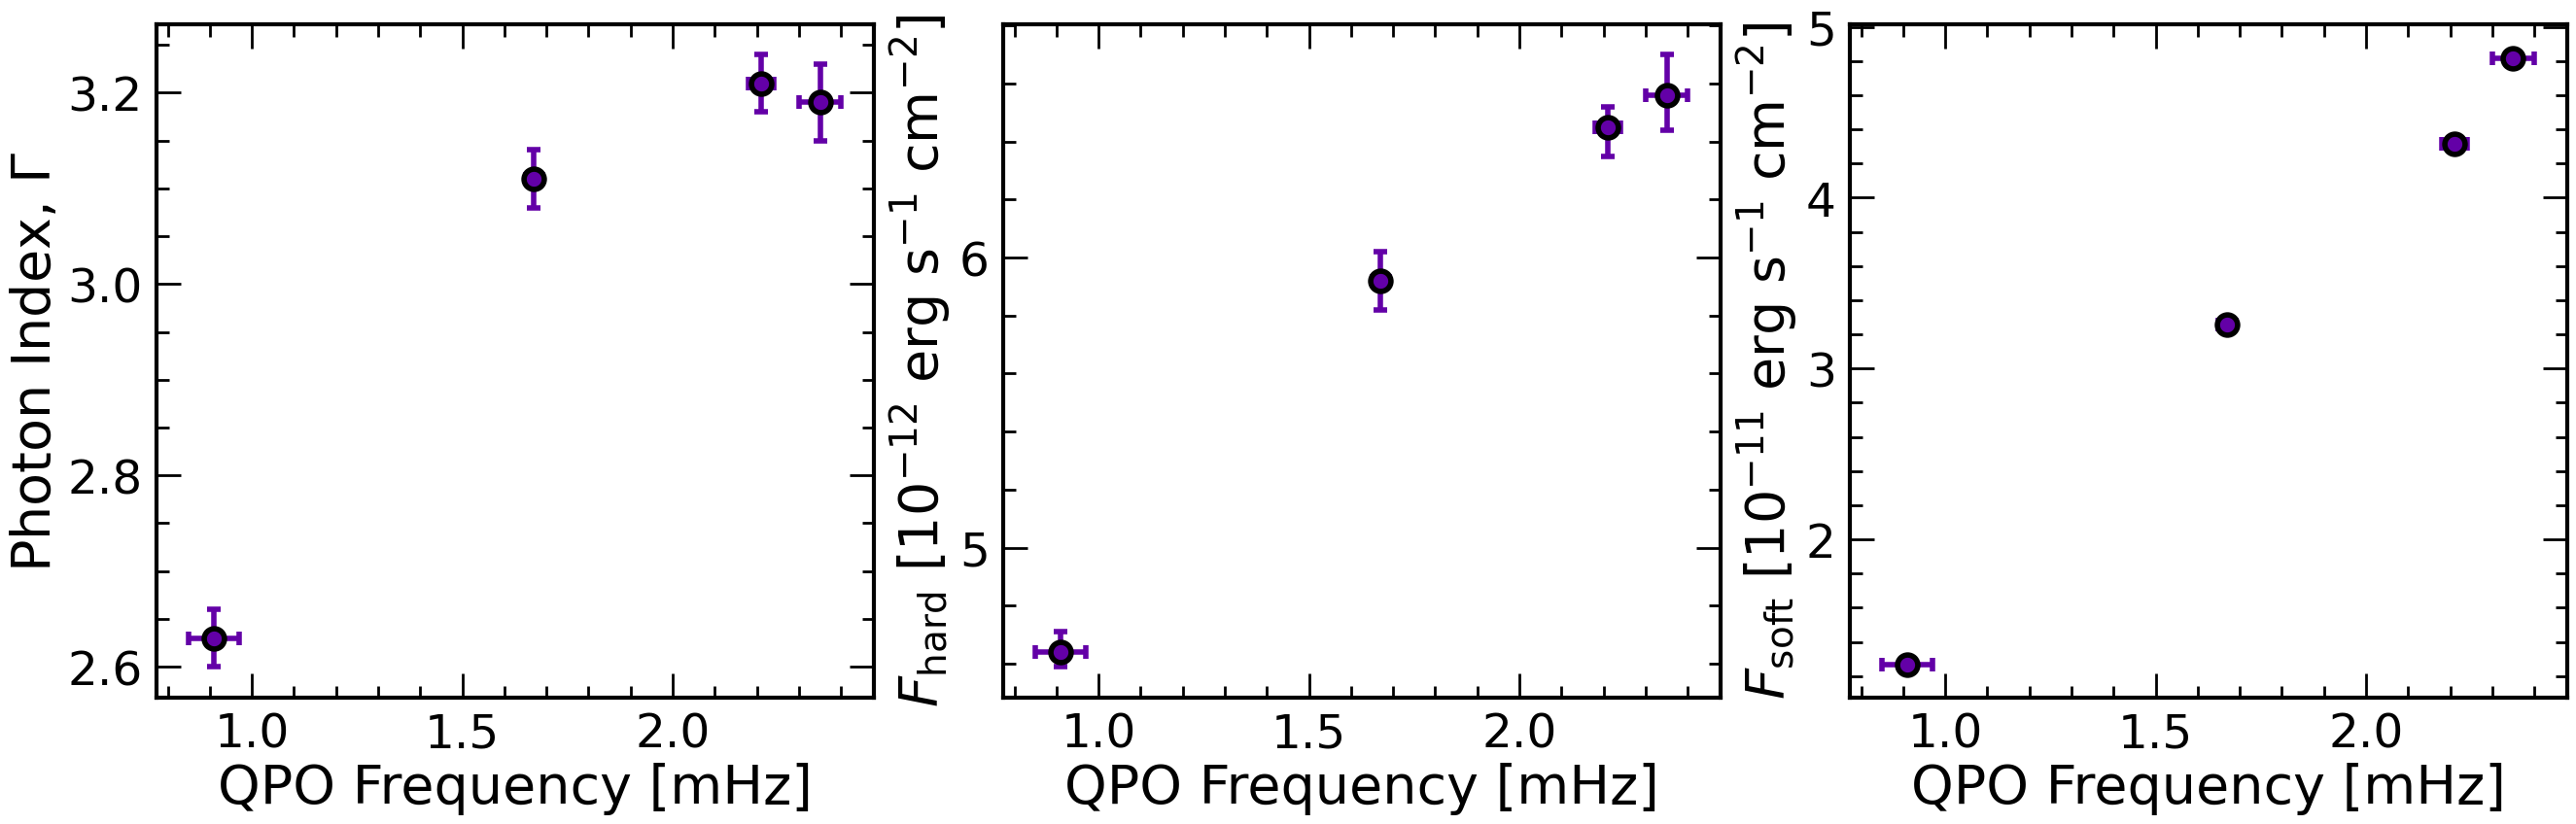

In [15]:
fig, axs = plt.subplots(figsize=(32,9), ncols=3, gridspec_kw={'wspace':0.18})
ax = axs[0]
ax.errorbar(qpo_freq, gamma, xerr=qpo_freq_err, yerr=[gamma_loerr, gamma_uperr], 
            fmt='o', ms=15, lw=4, capsize=5, color=save_color[-2], mew=4, mec='k')
ax.set_xlabel('QPO Frequency [mHz]')
ax.set_ylabel(r'Photon Index, $\Gamma$')
ax = axs[1]
ax.errorbar(qpo_freq, flux_2to10 / 1e-12, xerr=qpo_freq_err, yerr=[(flux_2to10-flux_2to10_lo) / 1e-12, (flux_2to10_up-flux_2to10) / 1e-12], 
            fmt='o', ms=15, lw=4, capsize=5, color=save_color[-2], mew=4, mec='k')
            # fmt='o', ms=15, lw=3, capsize=5, color=save_color[-2], mew=2, mec='k')
ax.set_xlabel('QPO Frequency [mHz]')
ax.set_ylabel(r'$F_\mathrm{hard}$ [$10^{-12}$ erg s$^{-1}$ cm$^{-2}$]')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.set_yscale('log')
ax = axs[2]
ax.errorbar(qpo_freq, flux_0p3to2 / 1e-11, xerr=qpo_freq_err, yerr=[flux_0p3to2_err[0,:] / 1e-11, flux_0p3to2_err[1,:] / 1e-11],
            fmt='o', ms=15, lw=4, capsize=5, color=save_color[-2], mew=4, mec='k')
ax.set_xlabel('QPO Frequency [mHz]')
ax.set_ylabel(r'$F_\mathrm{soft}$ [$10^{-11}$ erg s$^{-1}$ cm$^{-2}$]')
# ax.set_yscale('log')

if save: 
    plt.savefig(fig_path+'1ES_qpofreq_vs_fluxspec.pdf', bbox_inches='tight')

### Supp. Fig. 7

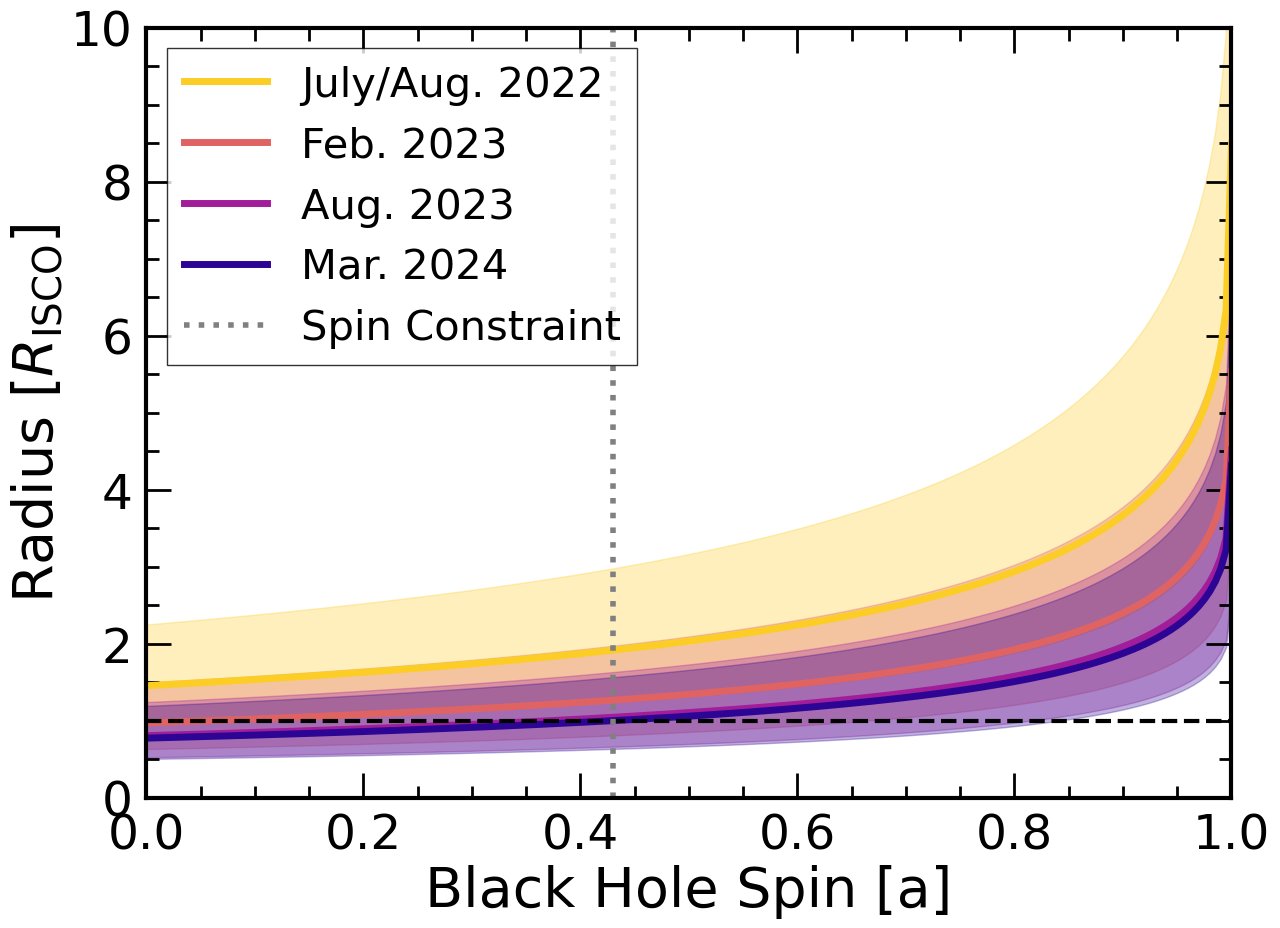

In [19]:
# where the QPO is coming from, assuming it arises from the Keplerian freq
def r(nu, M, a):
    return ( (const.c.cgs**3 / (2 * np.pi * const.G.cgs * M * const.M_sun.cgs * nu.cgs)) - a)**(2/3)
def r_isco(a):
    def solve(r,a):
        return 1 - (6 / r) + (8 * a / r**(3/2)) - (3 * a**2 / r**2)
    if isinstance(a,float):
        return opt.brentq(solve, 1e-3, 10, args=(a))
    else:
        r = np.zeros(len(a))
        for i in range(len(r)):
            r[i] = opt.brentq(solve, 1e-3, 10, args=(a[i]))
        return r
    
fig, ax = plt.subplots(figsize=(14,10))
a_grid = np.linspace(0,1,200)
cmap = plt.cm.plasma_r  # Choose a colormap
more_times = np.array([Time('2022-07-29').decimalyear, Time('2023-02-21').decimalyear, Time('2023-08-07').decimalyear, Time('2024-03-04').decimalyear])
norm = Normalize(vmin=more_times.min()-0.2, vmax=more_times.max()+0.1)
colors_qpo = cmap(norm(more_times))
M_best = 1.38e6
M_min = M_best - 0.66e6
M_max = M_best + 1.25e6
for i in range(len(qpo_freq)):
    ax.fill_between(a_grid, r(qpo_freq[i] * 1e-3 * u.Hz, M_min, a_grid) / r_isco(a_grid), r(qpo_freq[i] * 1e-3 * u.Hz, M_max, a_grid) / r_isco(a_grid), 
                    color=colors_qpo[i], alpha=0.3)
for i in range(len(qpo_freq)):
    ax.plot(a_grid, r(qpo_freq[i] * 1e-3 * u.Hz, M_best, a_grid) / r_isco(a_grid), color=colors_qpo[i], alpha=1, lw=5, ls='-', label=qpo_print_times[i])

ax.axhline(1, color='k', lw=3, ls='--')
ax.axvline(0.43, color='grey', lw=4, ls=':', label='Spin Constraint')
ax.set_xlabel('Black Hole Spin [a]')
ax.set_ylabel(r'Radius [$R_\mathrm{ISCO}$]')
ax.set_xlim(0,1)
ax.set_ylim(0,10)
ax.legend(fontsize=30, loc='upper left')

if save: 
    plt.savefig(fig_path+'1ES_qpoloc_ISCO.pdf', bbox_inches='tight')

### Supp. Fig. 8

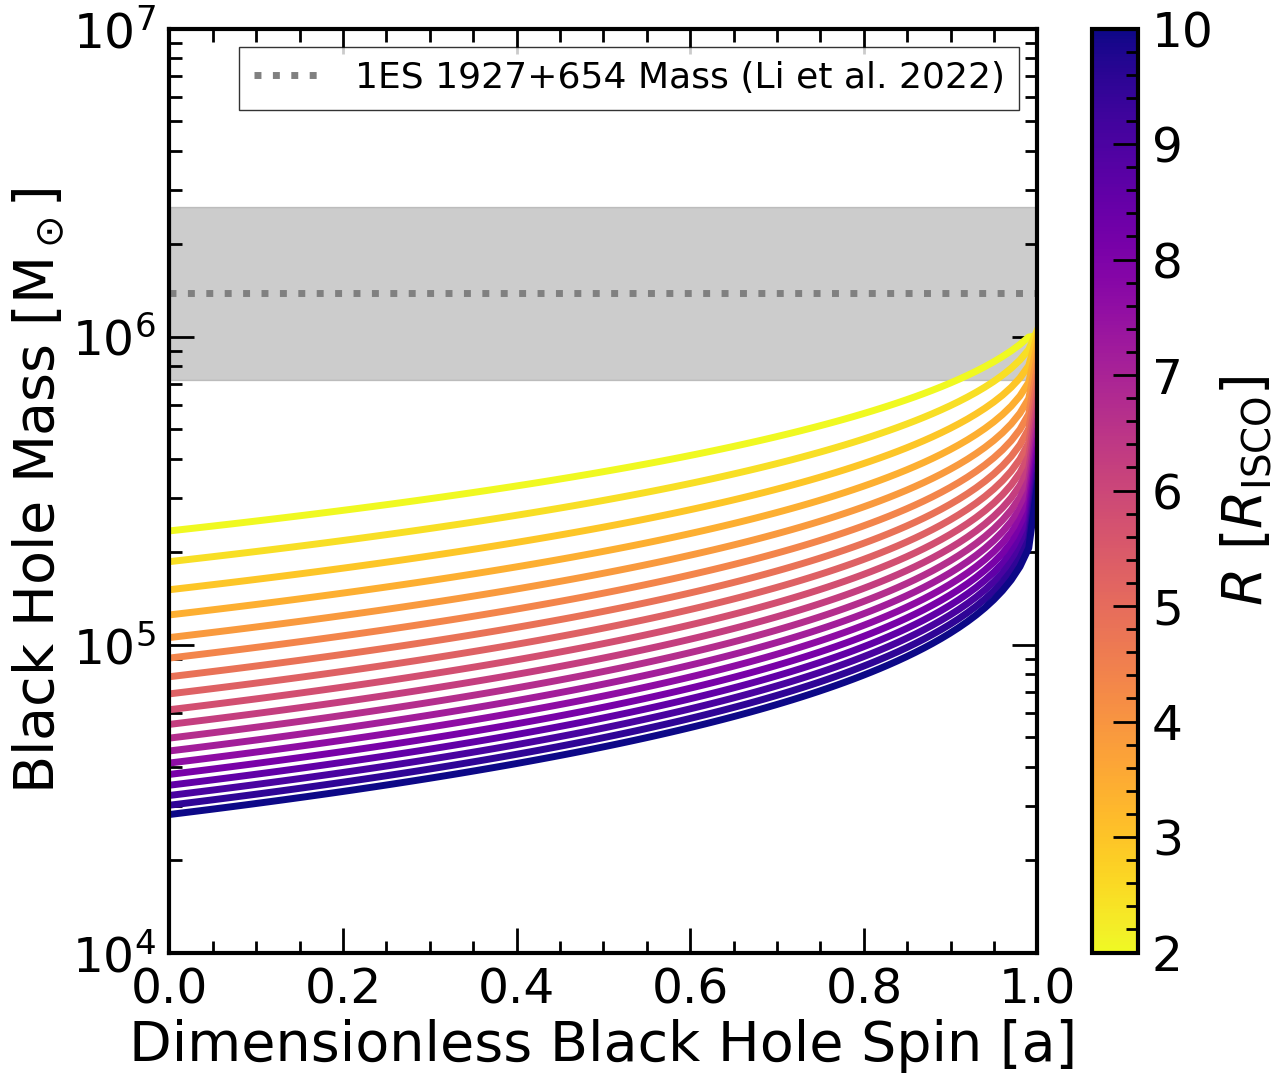

In [17]:
# ISCO 
def r_isco(a):
    def solve(r,a):
        return 1 - (6 / r) + (8 * a / r**(3/2)) - (3 * a**2 / r**2)
    if isinstance(a,float):
        return opt.brentq(solve, 1e-3, 10, args=(a))
    else:
        r = np.zeros(len(a))
        for i in range(len(r)):
            r[i] = opt.brentq(solve, 1e-3, 10, args=(a[i]))
        return r
    
# frequencies
# orbital frequency
def v_phi(r, a, M):
    term1 = (const.c**3 / (2 * np.pi * const.G * M * const.M_sun)).to(u.Hz).value
    term2 = (r**(3/2) + a)
    return term1 / term2
# radial frequency
def v_r(r, a, M):
    return v_phi(r, a, M) * np.sqrt(1 - (6 / r) + (8 * a / r**(3/2)) - (3 * a**2 / r**2))

# radial epicyclic frequency as a function of black hole mass and spin
a_grid = np.linspace(0.001,1,100)
v_obs = 2.35e-3 # Hz
# in units of ISCO 
r_grid = np.linspace(2, 10, 18)
M_r = np.zeros((len(a_grid), len(r_grid)))

cmap = plt.cm.plasma_r  # Choose a colormap
norm = Normalize(vmin=min(r_grid), vmax=max(r_grid))
colors = cmap(norm(r_grid))

fig, ax = plt.subplots(figsize=(14,12))

# loop over all of the spins
for j in range(len(r_grid)):
        
    for i in range(len(a_grid)):
                
        a = a_grid[i]
        # r = r_grid[j]
        r = r_isco(a) * r_grid[j]

        # radial 
        M_r[i,j] = opt.brentq(lambda M: v_r(r, a, M) - v_obs, 1e1, 1e9, full_output=False)

    ax.plot(a_grid, M_r[:,j], '-', color=colors[j], lw=5)

# ax.plot(a_grid, M_peri, '-', color='darkorange', lw=5, label='Periastron Precession @ ISCO')
ax.axhline(1.38e6, color='grey', ls=':', lw=5, label='1ES 1927+654 Mass (Li et al. 2022)')
ax.fill_between(a_grid, 1.38e6 - 0.66e6, 1.38e6 + 1.25e6, color='grey', alpha=0.4)
ax.set_xlabel('Dimensionless Black Hole Spin [a]')
ax.set_ylabel(r'Black Hole Mass [M$_\odot$]')
ax.set_yscale('log')
ax.set_ylim(1e4,1e7)
ax.set_xlim(0,1)
ax.legend(fontsize=26)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$R$ [$R_\mathrm{ISCO}$]')

if save:
    plt.savefig(fig_path+'1ES_radialepicyclic.pdf', bbox_inches='tight')